In [50]:
import pybaseball
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [162]:
import pybaseball
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_player_data_interactive():
    """
    Prompts user for player name & dates, looks up ID, fetches Statcast data.
    Returns the fetched data DataFrame, player's first name, last name,
    start date string, and end date string.
    Returns (None, None, None, None, None) if lookup or fetch fails.
    """
    # --- Get User Input ---
    first_name = input("Enter the player's first name: ").strip()
    last_name = input("Enter the player's last name: ").strip()

    while True:
        start_date_str = input("Enter the start date (YYYY-MM-DD): ").strip()
        try:
            datetime.strptime(start_date_str, '%Y-%m-%d')
            break
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")

    while True:
        end_date_str = input("Enter the end date (YYYY-MM-DD): ").strip()
        try:
            datetime.strptime(end_date_str, '%Y-%m-%d')
            if end_date_str < start_date_str:
                print("End date cannot be before the start date.")
            else:
                break
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")

    # --- Initialize variables before lookup ---
    player_id = None
    actual_first = None
    actual_last = None
    player_info = pd.DataFrame()

    # --- Look Up Player ID ---
    print(f"\nLooking up player ID for {first_name} {last_name}...")
    try:
        player_info = pybaseball.playerid_lookup(last_name, first_name, fuzzy=False)
        if player_info.empty:
            print("No exact match found, trying fuzzy search...")
            player_info = pybaseball.playerid_lookup(last_name, first_name, fuzzy=True)
            if player_info.empty:
                 print(f"Error: Could not find any player ID for {first_name} {last_name} after fuzzy search.")
                 # Let the check below handle the return

        # --- Handle Player Selection (only if player_info is not empty) ---
        if not player_info.empty:
            if len(player_info) == 1:
                player_id = int(player_info['key_mlbam'].iloc[0])
                actual_first = player_info['name_first'].iloc[0]
                actual_last = player_info['name_last'].iloc[0]
                print(f"Found Player: {actual_first} {actual_last} (ID: {player_id})")
            else:
                print(f"\nFound multiple players matching '{first_name} {last_name}'. Please choose one:")
                display_cols = ['name_first', 'name_last', 'key_mlbam', 'mlb_played_first', 'mlb_played_last']
                print(player_info[display_cols].to_markdown(index=False))
                valid_ids = player_info['key_mlbam'].tolist()
                while True:
                    try:
                        chosen_id_str = input(f"Enter the 'key_mlbam' for the player you want: ").strip()
                        chosen_id = int(chosen_id_str)
                        if chosen_id in valid_ids:
                            player_id = chosen_id
                            selected_player = player_info[player_info['key_mlbam'] == player_id].iloc[0]
                            actual_first = selected_player['name_first']
                            actual_last = selected_player['name_last']
                            print(f"Selected Player: {actual_first} {actual_last} (ID: {player_id})")
                            break
                        else:
                            print("Invalid ID. Please enter one of the 'key_mlbam' values listed above.")
                    except ValueError:
                        print("Invalid input. Please enter the numeric 'key_mlbam'.")
    except Exception as e:
        print(f"An error occurred during player lookup: {e}")

    # --- Check if Player ID was determined ---
    if player_id is None or actual_first is None or actual_last is None:
         print("Could not determine player ID after lookup attempts.")
         # Return None for all expected values
         return None, None, None, None, None
    # --- END Check ---

    # --- Fetch Statcast Data ---
    print(f"\nFetching Statcast data for {actual_first} {actual_last} ({player_id}) from {start_date_str} to {end_date_str}...")
    try:
        player_data = pybaseball.statcast_batter(start_dt=start_date_str, end_dt=end_date_str, player_id=player_id)

        if player_data.empty:
            print("No Statcast data found for this player and date range.")
            # Return success, but with empty data; include dates
            return player_data, actual_first, actual_last, start_date_str, end_date_str
        else:
            print(f"Successfully fetched {len(player_data)} pitches.")
            # Return fetched data, names, and dates
            return player_data, actual_first, actual_last, start_date_str, end_date_str

    except Exception as e:
        print(f"An error occurred while fetching Statcast data: {e}")
         # Return None for all expected values on fetch error
        return None, None, None, None, None

# --- Call the function and store results ---
# These variables will be used by Block 2 (added start_date and end_date)
player_statcast_data, player_first_name, player_last_name, start_date, end_date = get_player_data_interactive()

# Optional check after Block 1 runs
if player_statcast_data is None:
    print("\nBlock 1: Failed to retrieve data. Block 2 (Analysis) will not run.")
elif player_statcast_data.empty:
    print("\nBlock 1: Retrieved empty dataset (no pitches found for criteria). Block 2 (Analysis) might not show results.")
else:
     # Now includes dates in the success message variables
     print(f"\nBlock 1: Data retrieval successful for {start_date} to {end_date}. Variables ready for Block 2.")

Enter the player's first name:  nolan
Enter the player's last name:  jones
Enter the start date (YYYY-MM-DD):  2025-03-01
Enter the end date (YYYY-MM-DD):  2025-04-23



Looking up player ID for nolan jones...
Found Player: nolan jones (ID: 666134)

Fetching Statcast data for nolan jones (666134) from 2025-03-01 to 2025-04-23...
Gathering Player Data
Successfully fetched 464 pitches.

Block 1: Data retrieval successful for 2025-03-01 to 2025-04-23. Variables ready for Block 2.


In [164]:
# Block 1.5: Filter Out Unknown Batted Ball Types

print("\n--- Block 1.5: Filtering out Unknown Batted Ball Types ---")

# Check if data was successfully loaded in Block 1
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty:

    # Check if required columns exist for filtering
    if all(col in player_statcast_data.columns for col in ['launch_speed', 'launch_angle', 'bb_type']):

        # Identify batted balls (BBE)
        is_bbe = player_statcast_data['launch_speed'].notna() & player_statcast_data['launch_angle'].notna()

        # Identify BBEs with unknown type
        is_unknown_bbe = is_bbe & player_statcast_data['bb_type'].isna()

        # Count how many rows will be dropped
        rows_to_drop = is_unknown_bbe.sum()

        if rows_to_drop > 0:
            original_rows = len(player_statcast_data)
            # Keep rows that are NOT unknown BBEs
            # This keeps non-BBEs and BBEs with a known type
            player_statcast_data = player_statcast_data[~is_unknown_bbe].copy()
            print(f"Removed {rows_to_drop} rows corresponding to batted balls with Unknown bb_type.")
            print(f"DataFrame shape after filtering: {player_statcast_data.shape}")
        else:
            print("No batted balls with Unknown bb_type found to filter.")

    else:
        print("Warning: Cannot filter bb_type - required columns (launch_speed, launch_angle, bb_type) not found.")
else:
    print("Player data not available or empty, skipping bb_type filter.")

print("--- End of Block 1.5 ---")


--- Block 1.5: Filtering out Unknown Batted Ball Types ---
Removed 70 rows corresponding to batted balls with Unknown bb_type.
DataFrame shape after filtering: (394, 113)
--- End of Block 1.5 ---


In [166]:
# Block 2: Performs event analysis for the full date range using data from Block 1

print("\n--- Block 2: Analyzing Events for Full Date Range ---")

# Line 5 with typo and incomplete code REMOVED

# Check if data and date range were loaded successfully in Block 1
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date and \
   'player_first_name' in locals() and player_first_name and \
   'player_last_name' in locals() and player_last_name: # Added checks for name vars

    # Check if 'events' column exists
    if 'events' in player_statcast_data.columns:

        # Select non-null events from the *entire* fetched DataFrame
        all_events_in_range = player_statcast_data['events'].dropna()

        # Check if any events were found in the date range
        if not all_events_in_range.empty:
            # Analyze the full date range, title reflects this
            print(f"\n{player_first_name} {player_last_name} plate appearance event totals "
                  f"({start_date} to {end_date}):")
            # Perform the value counts on all events in the range
            print(all_events_in_range.value_counts().to_string()) # Use to_string for potentially long output
        else:
            # No events found in the entire specified range
            print(f"No recorded plate appearance events found for {player_first_name} {player_last_name} "
                  f"in the fetched data range ({start_date} to {end_date}).")
    else:
        # 'events' column missing
        print("Could not perform event analysis because the 'events' column is missing from the fetched data.")

elif 'player_statcast_data' not in locals() or player_statcast_data is None:
    # Message if data wasn't loaded successfully in Block 1
    print("Skipping event analysis because player data was not loaded successfully in Block 1.")
elif 'start_date' not in locals() or 'end_date' not in locals() or start_date is None or end_date is None:
     print("Skipping event analysis because start/end dates were not determined in Block 1.")
else: # Case where data is loaded but empty
     print(f"Skipping event analysis because the dataset fetched for {start_date} to {end_date} was empty.")


print("--- End of Block 2 ---")


--- Block 2: Analyzing Events for Full Date Range ---

nolan jones plate appearance event totals (2025-03-01 to 2025-04-23):
events
field_out                    39
strikeout                    29
single                       15
walk                         11
double                        7
grounded_into_double_play     2
force_out                     1
truncated_pa                  1
--- End of Block 2 ---


In [167]:
# Block 3: Visualize Home Run Launch Angle vs Launch Speed

print("\n--- Block 3: Visualizing Home Runs ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns for this analysis
    required_cols = ['events', 'launch_angle', 'launch_speed']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter to include home runs only, drop rows with missing launch data for plotting
        hr_data = player_statcast_data.loc[
            (player_statcast_data['events'] == 'home_run') &
            player_statcast_data['launch_angle'].notna() &
            player_statcast_data['launch_speed'].notna()
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Check if any home run data exists after filtering
        if not hr_data.empty:
            print(f"Found {len(hr_data)} home runs to visualize.")

            # Create dynamic titles using fetched data
            plot_title = f"{player_first_name} {player_last_name}\nHome Runs ({start_date} to {end_date})"
            plot_title_short = f"{player_first_name} {player_last_name} HRs" # For potentially smaller subplot titles if needed

            # --- Scatter Plot ---
            # Note: Original code had ncols=2 but only plotted on axs[0]. Adjusted to use one plot.
            # If comparing two players side-by-side was intended, the logic would need significant changes.
            fig_scatter, ax_scatter = plt.subplots(figsize=(7, 6)) # Create a single plot figure
            sns.regplot(
                x='launch_angle',
                y='launch_speed',
                fit_reg=False,      # Just the scatter points, no regression line
                color='tab:blue',
                data=hr_data,
                ax=ax_scatter       # Plot on the single axes
            )
            ax_scatter.set_title(plot_title)
            ax_scatter.set_xlabel("Launch Angle (degrees)")
            ax_scatter.set_ylabel("Launch Speed (mph)")
            plt.tight_layout() # Adjust layout
            # plt.show() # Display the scatter plot (optional if using notebook's auto-display)


            # --- KDE Plot ---
            # Similar adjustment: Original code had ncols=2, now using one plot.
            fig_kde, ax_kde = plt.subplots(figsize=(7, 6)) # Create a single plot figure
            sns.kdeplot(
                data=hr_data,
                x='launch_angle',
                y='launch_speed',
                cmap="Blues",       # Color map for density
                fill=True,         # Fill areas under contours
                thresh=0.05,        # Adjust threshold to control lowest level shown
                ax=ax_kde           # Plot on the single axes
            )
            ax_kde.set_title(plot_title)
            ax_kde.set_xlabel("Launch Angle (degrees)")
            ax_kde.set_ylabel("Launch Speed (mph)")
            plt.tight_layout() # Adjust layout
            plt.show() # Display plots (especially needed if not in notebook or to show both)


        else:
            # No home runs found in the data
            print(f"No home runs with complete launch data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping visualization because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    # Message if data wasn't loaded successfully in Block 1
    print("Skipping visualization because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping visualization because the dataset was empty or player/date info is missing.")

print("--- End of Block 3 ---")


--- Block 3: Visualizing Home Runs ---
No home runs with complete launch data found for nolan jones in the period 2025-03-01 to 2025-04-23.
--- End of Block 3 ---


In [168]:
# Block 4: Boxplot of Pitch Speed on Home Runs Hit by the Player

print("\n--- Block 4: Analyzing Pitch Speed on Home Runs Hit ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns for this analysis
    required_cols = ['events', 'release_speed']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter to include home runs only where pitch speed is available
        hr_data = player_statcast_data.loc[
            (player_statcast_data['events'] == 'home_run') &
            player_statcast_data['release_speed'].notna()
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Check if any home run data exists after filtering
        if not hr_data.empty:
            print(f"Found {len(hr_data)} home runs with pitch speed data to analyze.")

            # --- Add player name column for plotting ---
            # Since we only have one player, we add their name to each row
            # This allows using 'player_name' for the x-axis as in the original snippet
            full_name = f"{player_first_name} {player_last_name}"
            hr_data['player_name'] = full_name

            # Create dynamic title
            plot_title = f"{full_name}\nPitch Speed on HRs Hit ({start_date} to {end_date})"

            # --- Create Boxplot ---
            fig_box, ax_box = plt.subplots(figsize=(6, 6)) # Adjust figure size as needed
            sns.boxplot(
                x='player_name',    # Use the column we just added
                y='release_speed',
                data=hr_data,
                color='tab:blue',   # Use color from snippet
                ax=ax_box
            )
            # You could also add points using stripplot for more detail
            # sns.stripplot(x='player_name', y='release_speed', data=hr_data, color=".3", size=4, ax=ax_box)

            ax_box.set_title(plot_title)
            ax_box.set_xlabel("") # X-axis label might be redundant with only one player
            ax_box.set_ylabel("Pitch Speed (mph)")
            plt.tight_layout()
            plt.show()

        else:
            # No home runs with pitch speed found
            print(f"No home runs with pitch speed data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping pitch speed analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    # Message if data wasn't loaded successfully in Block 1
    print("Skipping pitch speed analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping pitch speed analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 4 ---")


--- Block 4: Analyzing Pitch Speed on Home Runs Hit ---
No home runs with pitch speed data found for nolan jones in the period 2025-03-01 to 2025-04-23.
--- End of Block 4 ---


In [169]:
def assign_x_coord(row):
    """
    Assigns an x-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Left third of strike zone
    if row.zone in [1, 4, 7]:
        return 1
    # Middle third of strike zone
    if row.zone in [2, 5, 8]:
        return 2
    # Right third of strike zone
    if row.zone in [3, 6, 9]:
        return 3
    
def assign_y_coord(row):
    """
    Assigns a y-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Upper third of strike zone
    if row.zone in [1, 2, 3]:
        return 3
    # Middle third of strike zone
    if row.zone in [4, 5, 6]:
        return 2
    # Lower third of strike zone
    if row.zone in [7, 8, 9]:
        return 1

In [170]:
# Block 5: Visualize Strike Zone Locations for Home Runs Hit

print("\n--- Block 5: Visualizing Strike Zone Home Runs ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns for this analysis
    required_cols = ['events', 'zone']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter directly from original data for home runs in zones 1-9
        # Ensure zone is not null before comparison
        strike_zone_hr = player_statcast_data.loc[
            (player_statcast_data['events'] == 'home_run') &
            player_statcast_data['zone'].notna() &
            (player_statcast_data['zone'] <= 9) # Filter for zones 1-9
        ].copy() # Use .copy()

        # Check if any strike zone home run data exists
        if not strike_zone_hr.empty:
            print(f"Found {len(strike_zone_hr)} home runs in the strike zone (zones 1-9) to visualize.")

            # Apply the coordinate assignment functions
            # Ensure 'zone' is treated as integer where possible after notna check
            strike_zone_hr['zone_x'] = strike_zone_hr.apply(assign_x_coord, axis=1)
            strike_zone_hr['zone_y'] = strike_zone_hr.apply(assign_y_coord, axis=1)

            # Drop any rows where coordinates couldn't be assigned (e.g., unexpected zone values somehow got through)
            strike_zone_hr.dropna(subset=['zone_x', 'zone_y'], inplace=True)

            if not strike_zone_hr.empty:
                # --- Create 2D Histogram ---
                plt.figure(figsize=(6, 6)) # Create a new figure
                plt.hist2d(
                    strike_zone_hr['zone_x'],
                    strike_zone_hr['zone_y'],
                    bins=3,        # 3x3 grid corresponding to zones
                    cmap='Blues'   # Color map from snippet
                )

                # Create dynamic title
                plot_title = f"{player_first_name} {player_last_name} Home Runs on\nPitches in the Strike Zone ({start_date} to {end_date})"
                plt.title(plot_title)

                # Hide axes as in the snippet
                plt.gca().get_xaxis().set_visible(False)
                plt.gca().get_yaxis().set_visible(False)

                # Add color bar
                cb = plt.colorbar()
                cb.set_label('Counts in Bin')

                plt.show()
            else:
                 print("Could not assign valid coordinates to any strike zone home runs.")

        else:
            # No strike zone home runs found
            print(f"No home runs hit on pitches in the strike zone (zones 1-9) found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping strike zone analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    # Message if data wasn't loaded successfully in Block 1
    print("Skipping strike zone analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping strike zone analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 5 ---")


--- Block 5: Visualizing Strike Zone Home Runs ---
No home runs hit on pitches in the strike zone (zones 1-9) found for nolan jones in the period 2025-03-01 to 2025-04-23.
--- End of Block 5 ---



--- Block 6: Analyzing Batting Average by Pitch Location ---
Found 94 At Bats with location data to analyze.


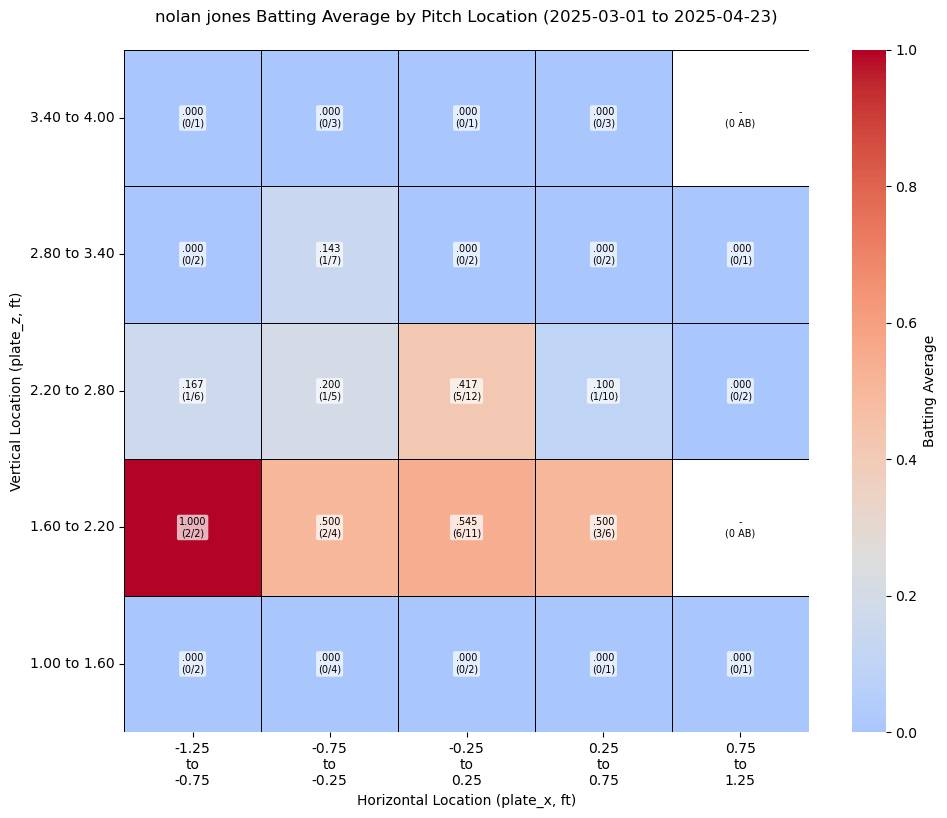

--- End of Block 6 ---


In [171]:
# Block 6: Visualize Batting Average by Pitch Location (Manual Annotations)

print("\n--- Block 6: Analyzing Batting Average by Pitch Location ---")

# Check prerequisite data and variables from Block 1 (Batter Notebook)
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # Add necessary imports if not already done globally
    try: pd; np; plt; sns
    except NameError: import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

    # Define required columns
    required_cols = ['events', 'plate_x', 'plate_z']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        pitch_data = player_statcast_data[
            player_statcast_data['events'].notna() &
            player_statcast_data['plate_x'].notna() &
            player_statcast_data['plate_z'].notna() # Correct variable name
        ].copy()

        hit_events = {'single', 'double', 'triple', 'home_run'}
        non_ab_events = {'walk', 'hit_by_pitch', 'sac_fly', 'sac_bunt',
                         'catcher_int', 'intent_walk', 'fan_interference',
                         'error', 'fielders_choice'}

        pitch_data['is_hit'] = pitch_data['events'].isin(hit_events)
        pitch_data['is_ab'] = (~pitch_data['events'].isin(non_ab_events)) & (pitch_data['events'].notna())
        ab_data = pitch_data[pitch_data['is_ab'] == True].copy()

        if not ab_data.empty:
            print(f"Found {len(ab_data)} At Bats with location data to analyze.")

            # --- Grid Definition (5x5) ---
            x_bins = np.linspace(-1.25, 1.25, 6)
            z_bins = np.linspace(1.0, 4.0, 6)
            ab_data['x_zone_bin'] = pd.cut(ab_data['plate_x'], bins=x_bins)
            ab_data['z_zone_bin'] = pd.cut(ab_data['plate_z'], bins=z_bins)
            ab_data.dropna(subset=['x_zone_bin', 'z_zone_bin'], inplace=True)

            if not ab_data.empty:
                # --- Calculation ---
                zone_stats = ab_data.groupby(['z_zone_bin', 'x_zone_bin'], observed=False).agg(
                    Hits=('is_hit', 'sum'),
                    AB=('is_ab', 'count')
                ).reset_index()
                zone_stats['BA'] = zone_stats['Hits'] / zone_stats['AB'] # BA is NaN if AB=0

                # --- Pivot Data and Create Annotations (Strings) --- ## REVERT TO STRING ANNOTATIONS ##
                ba_heatmap_data = None; annot_labels = None
                hits_pivot = None; ab_pivot = None
                try:
                    ba_heatmap_data = zone_stats.pivot_table(index='z_zone_bin', columns='x_zone_bin', values='BA', observed=False)
                    hits_pivot = zone_stats.pivot_table(index='z_zone_bin', columns='x_zone_bin', values='Hits', observed=False, fill_value=0)
                    ab_pivot = zone_stats.pivot_table(index='z_zone_bin', columns='x_zone_bin', values='AB', observed=False, fill_value=0)

                    # Create the string annotation labels again
                    annot_labels = pd.DataFrame(index=ba_heatmap_data.index, columns=ba_heatmap_data.columns, dtype=str)
                    for row_idx in ba_heatmap_data.index:
                        for col_idx in ba_heatmap_data.columns:
                            hits = hits_pivot.loc[row_idx, col_idx]
                            ab = ab_pivot.loc[row_idx, col_idx]
                            if ab > 0:
                                ba_val = ba_heatmap_data.loc[row_idx, col_idx]
                                ba_str = f"{ba_val:.3f}".lstrip('0') if pd.notna(ba_val) else ".---"
                                annot_labels.loc[row_idx, col_idx] = f"{ba_str}\n({hits:.0f}/{ab:.0f})"
                            else:
                                annot_labels.loc[row_idx, col_idx] = "-\n(0 AB)" # Explicit label for zero ABs

                except Exception as e:
                    print(f"Error creating pivot table or annotations for heatmap: {e}")
                    ba_heatmap_data = None; annot_labels = None

                # --- Visualization (Manual Annotations) --- ## MODIFIED ##
                if ba_heatmap_data is not None and not ba_heatmap_data.empty and annot_labels is not None:
                    plt.figure(figsize=(10, 9))
                    ax = plt.gca()
                    sns.heatmap(
                        ba_heatmap_data,
                        annot=False,          # <-- Draw heatmap without annotations
                        fmt="",
                        cmap='coolwarm',
                        center=0.250,
                        linewidths=.5,
                        linecolor='k',
                        cbar_kws={'label': 'Batting Average'},
                        # na_color='whitesmoke', # This caused errors
                        # annot_kws={"size": 7}, # Set fontsize in ax.text
                        ax=ax
                    )

                    # --- Manually Add Text Annotations with Background ---
                    bbox_props = dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none')
                    for i in range(annot_labels.shape[0]): # Rows (0-4)
                         for j in range(annot_labels.shape[1]): # Cols (0-4)
                            label = annot_labels.iloc[i, j]
                            # Use black text + background box for contrast
                            ax.text(j + 0.5, i + 0.5, label,
                                    ha='center', va='center', color='black', fontsize=7,
                                    bbox=bbox_props)
                    # ----------------------------------------------------

                    # Improve axis labels to show bin ranges
                    x_tick_labels = [f"{b.left:.2f}\nto\n{b.right:.2f}" for b in ba_heatmap_data.columns]
                    z_tick_labels = [f"{b.left:.2f} to {b.right:.2f}" for b in ba_heatmap_data.index]
                    plt.xticks(ticks=np.arange(len(ba_heatmap_data.columns)) + 0.5, labels=x_tick_labels, rotation=0)
                    plt.yticks(ticks=np.arange(len(ba_heatmap_data.index)) + 0.5, labels=z_tick_labels, rotation=0)
                    ax.invert_yaxis() # Correct orientation

                    plt.xlabel("Horizontal Location (plate_x, ft)")
                    plt.ylabel("Vertical Location (plate_z, ft)")
                    plot_title = f"{player_first_name} {player_last_name} Batting Average by Pitch Location ({start_date} to {end_date})"
                    plt.title(plot_title, pad=20)
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.show()
                else:
                    print("No data available to plot heatmap after binning and pivoting.")
            else:
                print("No At Bats found within the defined 5x5 grid boundaries.")
        else:
            print(f"No At Bats found for {player_first_name} {player_last_name} in the specified date range.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping BA analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping BA analysis because player data was not loaded successfully in Block 1.")
else:
     print("Skipping BA analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 6 ---")

In [172]:
def is_barrel(launch_speed, launch_angle):
    """
    Determines if a batted ball is a Statcast Barrel based on approximate criteria.

    Args:
        launch_speed (float): Exit velocity in mph.
        launch_angle (float): Launch angle in degrees.

    Returns:
        bool: True if the batted ball is a Barrel, False otherwise.
    """
    # Ensure input are numeric, return False if not
    if pd.isna(launch_speed) or pd.isna(launch_angle):
        return False

    # Check minimum EV
    if launch_speed < 98:
        return False

    # Define LA bounds based on EV
    min_la_barrel = 0.0
    max_la_barrel = 0.0

    if launch_speed >= 116:
        min_la_barrel = 8.0
        max_la_barrel = 50.0
    elif launch_speed >= 100:
        # Linear interpolation between (100 mph, LA 24-33) and (116 mph, LA 8-50)
        # Lower bound slope: (8 - 24) / (116 - 100) = -1
        # Upper bound slope: (50 - 33) / (116 - 100) = 1.0625
        min_la_barrel = 24.0 - (launch_speed - 100.0) * 1.0
        max_la_barrel = 33.0 + (launch_speed - 100.0) * 1.0625
    elif launch_speed == 99:
        min_la_barrel = 25.0
        max_la_barrel = 31.0
    elif launch_speed == 98:
        min_la_barrel = 26.0
        max_la_barrel = 30.0
    else: # Should not happen based on initial check, but good practice
        return False

    # Check if launch angle is within the calculated bounds
    return (launch_angle >= min_la_barrel) and (launch_angle <= max_la_barrel)

print("Helper function is_barrel defined.")

Helper function is_barrel defined.



--- Block 7: Defining Barrel Function and Analyzing Exit Velocity ---

Helper function 'is_barrel' defined.

Analyzing Exit Velocity by Batted Ball Type (Barrels Highlighted)...
Found 64 batted balls with EV/LA data, including 5 barrels.


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


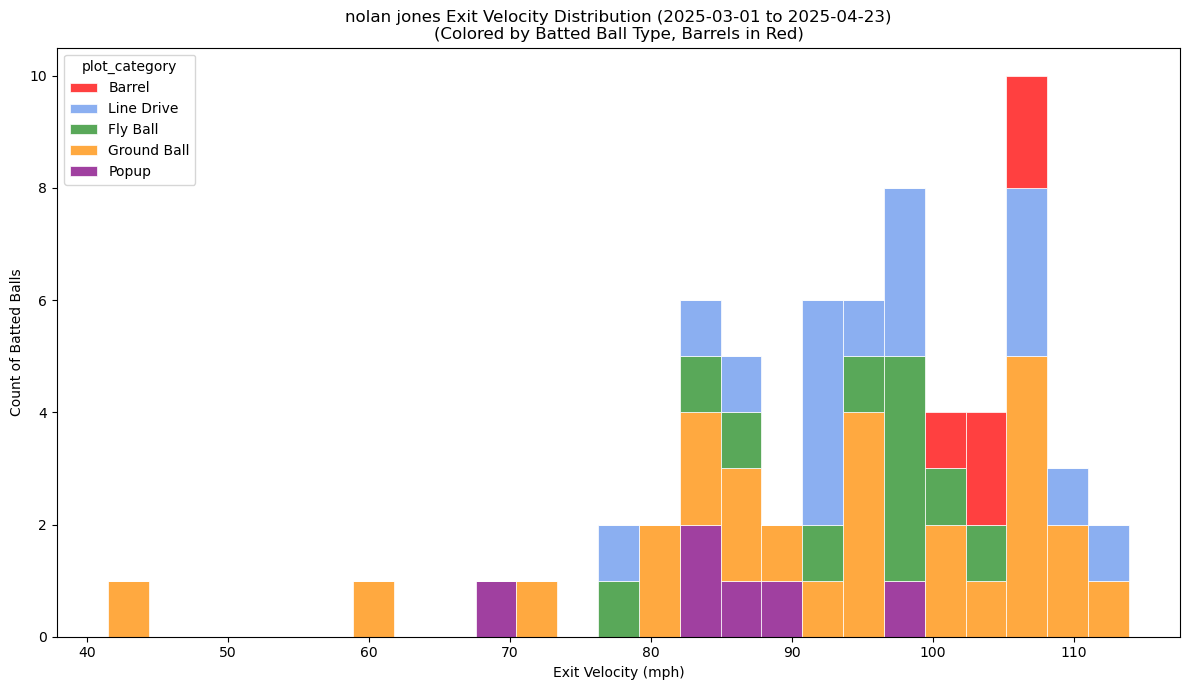

--- End of Block 7 ---


In [173]:
# Block 7: Define Barrel Function & Visualize EV Histogram

print("\n--- Block 7: Defining Barrel Function and Analyzing Exit Velocity ---")

# --- Block 7a: Define is_barrel helper function ---
# Make sure pandas and numpy are available
try: pd; np
except NameError: import pandas as pd; import numpy as np

def is_barrel(launch_speed, launch_angle):
    """
    Determines if a batted ball is a Statcast Barrel based on approximate criteria.
    Args: launch_speed (float), launch_angle (float)
    Returns: bool
    """
    if pd.isna(launch_speed) or pd.isna(launch_angle): return False
    if launch_speed < 98: return False
    min_la_barrel = 0.0; max_la_barrel = 0.0
    if launch_speed >= 116:
        min_la_barrel = 8.0; max_la_barrel = 50.0
    elif launch_speed >= 100:
        # Linear interpolation between (100 mph, LA 24-33) and (116 mph, LA 8-50)
        min_la_barrel = 24.0 - (launch_speed - 100.0) * 1.0
        max_la_barrel = 33.0 + (launch_speed - 100.0) * 1.0625
    elif launch_speed == 99:
        min_la_barrel = 25.0; max_la_barrel = 31.0
    elif launch_speed == 98:
        min_la_barrel = 26.0; max_la_barrel = 30.0
    else: # Should not happen based on initial EV check < 98
        return False
    # Check if launch angle is within the calculated bounds
    return (launch_angle >= min_la_barrel) and (launch_angle <= max_la_barrel)

print("\nHelper function 'is_barrel' defined.")
# ---------------------------------------------------------

# --- Block 7b: Exit Velocity Histogram by Batted Ball Type (Corrected Legend) ---
print("\nAnalyzing Exit Velocity by Batted Ball Type (Barrels Highlighted)...")

# Check prerequisite data and variables from Block 1 (Batter Notebook)
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # Make sure necessary plotting libraries are imported
    try: plt; sns
    except NameError: import matplotlib.pyplot as plt; import seaborn as sns

    # Define required columns for this analysis
    required_cols = ['launch_speed', 'launch_angle', 'bb_type']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter for batted balls with necessary data
        batted_ball_data = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna()
        ].copy()

        if not batted_ball_data.empty:
            # --- Apply Barrel Definition ---
            batted_ball_data['is_barrel'] = batted_ball_data.apply(
                lambda row: is_barrel(row['launch_speed'], row['launch_angle']),
                axis=1
            )

            # --- Create Plotting Category ---
            def assign_plot_category(row):
                if row['is_barrel']: return "Barrel"
                elif pd.notna(row['bb_type']): return row['bb_type'].replace('_', ' ').title()
                else: return "Unknown"
            batted_ball_data['plot_category'] = batted_ball_data.apply(assign_plot_category, axis=1)

            barrel_count = batted_ball_data['is_barrel'].sum()
            print(f"Found {len(batted_ball_data)} batted balls with EV/LA data, including {barrel_count} barrels.")

            # --- Visualization ---
            plt.figure(figsize=(12, 7))

            # Define desired category order and colors
            category_order = ["Barrel", "Line Drive", "Fly Ball", "Ground Ball", "Popup"]
            palette = {
                "Barrel": "red", "Line Drive": "cornflowerblue", "Fly Ball": "forestgreen",
                "Ground Ball": "darkorange", "Popup": "purple"
            }
            # Filter order and palette based on categories actually present in the data
            present_categories = batted_ball_data['plot_category'].unique()
            plot_hue_order = [cat for cat in category_order if cat in present_categories]
            plot_palette = {k: v for k, v in palette.items() if k in present_categories}

            # Create the histogram
            sns.histplot(
                data=batted_ball_data,
                x='launch_speed',
                hue='plot_category',
                hue_order=plot_hue_order, # Specify order for stacking and legend
                palette=plot_palette,   # Use the filtered palette
                multiple='stack',
                bins=25,
                edgecolor='white',
                linewidth=0.5
                # Legend is handled automatically by histplot when hue is set
            )

            plt.title(f"{player_first_name} {player_last_name} Exit Velocity Distribution ({start_date} to {end_date})\n(Colored by Batted Ball Type, Barrels in Red)")
            plt.xlabel("Exit Velocity (mph)")
            plt.ylabel("Count of Batted Balls")
            # No manual plt.legend() needed here
            plt.tight_layout()
            plt.show()

        else:
            print(f"No batted balls with launch speed and launch angle data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping EV histogram because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping EV histogram because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping EV histogram because the dataset was empty or player/date info is missing.")

print("--- End of Block 7 ---")

In [174]:
# Block 23: Investigate Batted Ball Types

print("\n--- Block 23: Investigating Batted Ball Types ---")

# Check prerequisite data and variables from Block 1 (Batter Notebook)
# Ensure variables like player_statcast_data, player_first_name, start_date, end_date exist
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name:

    # --- Define Required Columns ---
    required_cols = ['bb_type', 'launch_speed', 'launch_angle']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation: Filter for Batted Balls ---
        # Ensure we only look at actual batted ball events
        batted_ball_data = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna()
        ].copy()

        if not batted_ball_data.empty:
            print(f"Analyzing 'bb_type' for {len(batted_ball_data)} batted balls hit by {player_first_name} {player_last_name}...")

            # --- Analyze bb_type ---
            # Show all unique values found in the column
            unique_bb_types = batted_ball_data['bb_type'].unique()
            print("\nUnique 'bb_type' values found:")
            print(unique_bb_types) # Will show NaN if present

            # Show percentage breakdown, including missing values
            print("\nPercentage distribution of 'bb_type' (including missing/NaN):")
            bb_type_distribution = batted_ball_data['bb_type'].value_counts(dropna=False, normalize=True) * 100
            print(bb_type_distribution.to_string(float_format="%.1f%%"))

            if bb_type_distribution.isnull().any() or np.nan in unique_bb_types:
                 print("\nNote: 'NaN' represents batted balls where the type was not recorded (Unknown).")

        else:
            print("No batted ball data found in the specified period to analyze.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping bb_type investigation because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping bb_type investigation because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping bb_type investigation because the dataset was empty or player/date info is missing.")

print("--- End of Block 23 ---")


--- Block 23: Investigating Batted Ball Types ---
Analyzing 'bb_type' for 64 batted balls hit by nolan jones...

Unique 'bb_type' values found:
['ground_ball' 'line_drive' 'fly_ball' 'popup']

Percentage distribution of 'bb_type' (including missing/NaN):
bb_type
ground_ball   40.6%
line_drive    28.1%
fly_ball      21.9%
popup          9.4%
--- End of Block 23 ---



--- Block 8: Analyzing Launch Angle by Batted Ball Type (Barrels Highlighted) ---
Found 64 batted balls with EV/LA data, including 5 barrels.


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


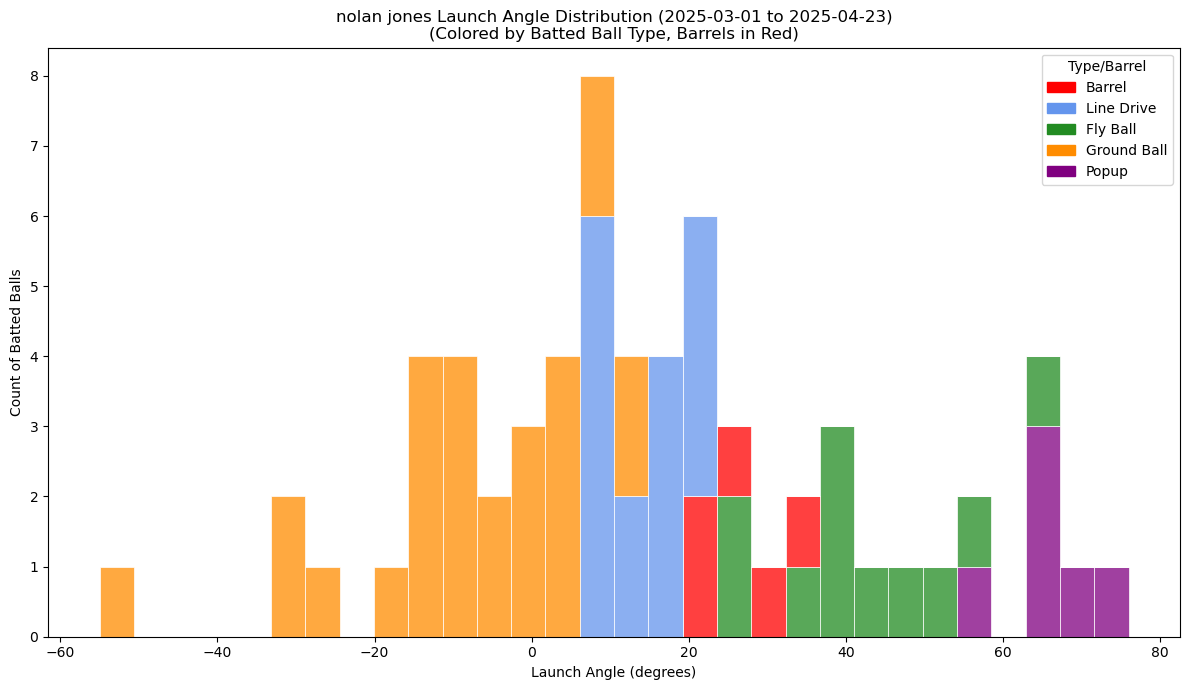

--- End of Block 8 ---


In [175]:
# Block 8: Launch Angle Histogram by Batted Ball Type & Barrels

print("\n--- Block 8: Analyzing Launch Angle by Batted Ball Type (Barrels Highlighted) ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns for this analysis (need EV and LA for barrel calc)
    required_cols = ['launch_speed', 'launch_angle', 'bb_type']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter for batted balls with necessary data
        batted_ball_data_la = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna()
            # We will handle potential null bb_type later
        ].copy()

        if not batted_ball_data_la.empty:
            # --- Apply Barrel Definition ---
            # Ensure is_barrel function from Block 7a is available
            try:
                batted_ball_data_la['is_barrel'] = batted_ball_data_la.apply(
                    lambda row: is_barrel(row['launch_speed'], row['launch_angle']),
                    axis=1
                )
            except NameError:
                 print("Error: 'is_barrel' function not defined. Please run Block 7a first.")
                 batted_ball_data_la = None # Prevent further processing

            # --- Create Plotting Category (if barrel calc succeeded) ---
            if batted_ball_data_la is not None:
                # Combine bb_type and barrel status
                def assign_plot_category(row):
                    if row['is_barrel']:
                        return "Barrel"
                    elif pd.notna(row['bb_type']):
                        return row['bb_type'].replace('_', ' ').title() # Format nicely
                    else:
                        return "Unknown"

                batted_ball_data_la['plot_category'] = batted_ball_data_la.apply(assign_plot_category, axis=1)

                # Count barrels found
                barrel_count = batted_ball_data_la['is_barrel'].sum()
                print(f"Found {len(batted_ball_data_la)} batted balls with EV/LA data, including {barrel_count} barrels.")

                # --- Visualization ---
                plt.figure(figsize=(12, 7))

                # Define colors - ensure 'Barrel' is distinct
                palette = {
                    "Barrel": "red",
                    "Line Drive": "cornflowerblue",
                    "Fly Ball": "forestgreen",
                    "Ground Ball": "darkorange",
                    "Popup": "purple",
                    "Unknown": "grey"
                }
                # Filter palette to only include categories present in the data
                present_categories = batted_ball_data_la['plot_category'].unique()
                plot_palette = {k: v for k, v in palette.items() if k in present_categories}

                # Create the histogram using the combined category for hue
                sns.histplot(
                    data=batted_ball_data_la,
                    x='launch_angle',        # <-- Changed variable to launch_angle
                    hue='plot_category',
                    palette=plot_palette,
                    multiple='stack',        # Stack bars to show composition
                    bins=30,                 # Adjust bin count as needed for angles
                    edgecolor='white',       # Add edge color for better separation
                    linewidth=0.5
                )

                plt.title(f"{player_first_name} {player_last_name} Launch Angle Distribution ({start_date} to {end_date})\n(Colored by Batted Ball Type, Barrels in Red)")
                plt.xlabel("Launch Angle (degrees)") # <-- Changed label
                plt.ylabel("Count of Batted Balls")
                # Create legend manually to ensure correct order/labels if needed
                handles = [plt.Rectangle((0,0),1,1, color=plot_palette[label]) for label in plot_palette.keys()]
                plt.legend(handles, plot_palette.keys(), title='Type/Barrel')
                plt.tight_layout()
                plt.show()
            # End if barrel calc succeeded
        else:
            print(f"No batted balls with launch speed and launch angle data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping LA histogram because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping LA histogram because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping LA histogram because the dataset was empty or player/date info is missing.")

print("--- End of Block 8 ---")


--- Block 9: Visualizing Exit Velocity vs Launch Angle ---
Found 64 batted balls with EV/LA data, including 5 barrels.


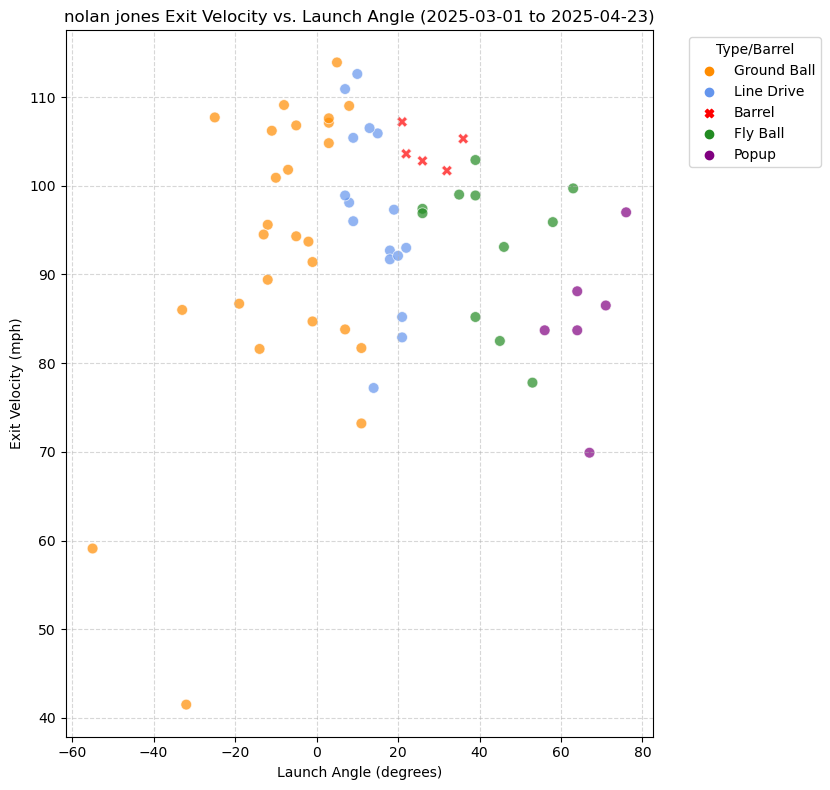

--- End of Block 9 ---


In [176]:
# Block 9: Exit Velocity vs Launch Angle Scatter Plot

print("\n--- Block 9: Visualizing Exit Velocity vs Launch Angle ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns for this analysis (need EV and LA for barrel calc)
    required_cols = ['launch_speed', 'launch_angle', 'bb_type']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Filter for batted balls with necessary data
        batted_ball_data_scatter = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna()
            # We will handle potential null bb_type later
        ].copy()

        if not batted_ball_data_scatter.empty:
            # --- Apply Barrel Definition ---
            # Ensure is_barrel function from Block 7a is available
            try:
                batted_ball_data_scatter['is_barrel'] = batted_ball_data_scatter.apply(
                    lambda row: is_barrel(row['launch_speed'], row['launch_angle']),
                    axis=1
                )
            except NameError:
                 print("Error: 'is_barrel' function not defined. Please run Block 7a first.")
                 batted_ball_data_scatter = None # Prevent further processing

            # --- Create Plotting Category (if barrel calc succeeded) ---
            if batted_ball_data_scatter is not None:
                # Combine bb_type and barrel status
                def assign_plot_category(row):
                    if row['is_barrel']:
                        return "Barrel"
                    elif pd.notna(row['bb_type']):
                        return row['bb_type'].replace('_', ' ').title() # Format nicely
                    else:
                        return "Unknown"

                batted_ball_data_scatter['plot_category'] = batted_ball_data_scatter.apply(assign_plot_category, axis=1)

                # Count barrels found
                barrel_count = batted_ball_data_scatter['is_barrel'].sum()
                print(f"Found {len(batted_ball_data_scatter)} batted balls with EV/LA data, including {barrel_count} barrels.")

                # --- Visualization ---
                plt.figure(figsize=(10, 8))

                # Define colors and markers - ensure 'Barrel' is distinct
                palette = {
                    "Barrel": "red",
                    "Line Drive": "cornflowerblue",
                    "Fly Ball": "forestgreen",
                    "Ground Ball": "darkorange",
                    "Popup": "purple",
                    "Unknown": "grey"
                }
                markers = {
                    "Barrel": "X", # Use 'X' or '*' for barrels
                    "Line Drive": "o",
                    "Fly Ball": "o",
                    "Ground Ball": "o",
                    "Popup": "o",
                    "Unknown": "."
                }

                # Filter palette/markers to only include categories present in the data
                present_categories = batted_ball_data_scatter['plot_category'].unique()
                plot_palette = {k: v for k, v in palette.items() if k in present_categories}
                plot_markers = {k: v for k, v in markers.items() if k in present_categories}


                # Create the scatter plot using hue and style
                sns.scatterplot(
                    data=batted_ball_data_scatter,
                    x='launch_angle',
                    y='launch_speed',
                    hue='plot_category',
                    style='plot_category', # Use category for marker style too
                    palette=plot_palette,  # Use filtered color palette
                    markers=plot_markers,  # Use filtered marker map
                    s=60,                  # Adjust point size
                    alpha=0.7              # Add some transparency
                )

                plt.title(f"{player_first_name} {player_last_name} Exit Velocity vs. Launch Angle ({start_date} to {end_date})")
                plt.xlabel("Launch Angle (degrees)")
                plt.ylabel("Exit Velocity (mph)")
                plt.grid(True, linestyle='--', alpha=0.5) # Add grid for better readability
                plt.legend(title='Type/Barrel', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
                plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
                plt.show()
            # End if barrel calc succeeded
        else:
            print(f"No batted balls with launch speed and launch angle data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping EV/LA scatter plot because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping EV/LA scatter plot because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping EV/LA scatter plot because the dataset was empty or player/date info is missing.")

print("--- End of Block 9 ---")


--- Block 10: Analyzing Rolling Hard Hit Rate ---


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


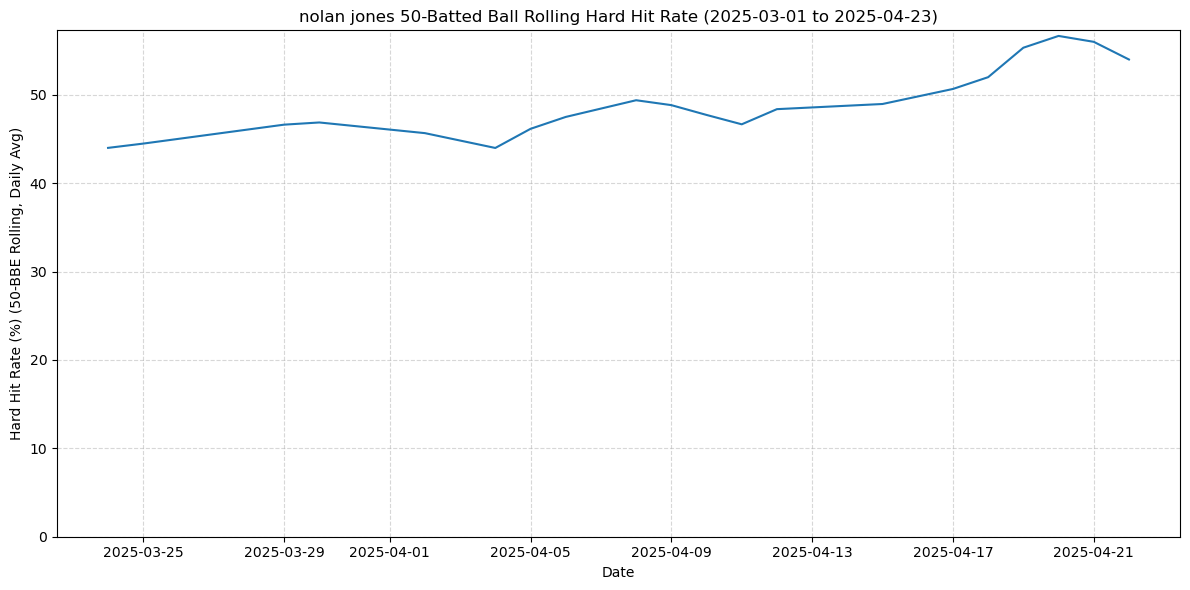

--- End of Block 10 ---


In [177]:
# Block 10: Rolling Hard Hit Rate Over Time (Corrected for Duplicate Dates)

print("\n--- Block 10: Analyzing Rolling Hard Hit Rate ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns
    required_cols = ['launch_speed', 'game_date']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for batted balls with valid launch speed and game date
        batted_ball_data_hh = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['game_date'].notna()
        ].copy()

        if not batted_ball_data_hh.empty:
            # 2. Ensure game_date is datetime and sort chronologically (CRITICAL for rolling calcs)
            batted_ball_data_hh['game_date'] = pd.to_datetime(batted_ball_data_hh['game_date'])
            batted_ball_data_hh.sort_values(by='game_date', inplace=True)

            # 3. Define Hard Hit and create boolean column
            hard_hit_threshold = 95.0
            batted_ball_data_hh['is_hard_hit'] = batted_ball_data_hh['launch_speed'] >= hard_hit_threshold

            # 4. Define rolling window size (number of batted balls)
            window_size = 50 # Use a 50-batted-ball rolling window (adjust as needed)

            # Check if there's enough data for the window
            if len(batted_ball_data_hh) >= window_size:
                # --- Calculate Rolling Hard Hit Rate ---
                rolling_col_name = f'rolling_hh_rate_{window_size}'
                batted_ball_data_hh[rolling_col_name] = batted_ball_data_hh['is_hard_hit'].rolling(
                    window=window_size,
                    min_periods=window_size // 2 # Allow calculation with half window at start
                ).mean() * 100

                # --- Aggregate by Date for Plotting (Fix for Duplicate Dates) --- ## ADDED STEP ##
                # Group by date and take the mean of the rolling value for that day
                # This ensures each date has only one value for plotting
                daily_rolling_hh = batted_ball_data_hh.groupby('game_date')[rolling_col_name].mean().reset_index()

                # --- Visualization ---
                plt.figure(figsize=(12, 6))

                sns.lineplot(
                    data=daily_rolling_hh, # <-- Plot the aggregated daily data
                    x='game_date',
                    y=rolling_col_name,    # <-- Use the same rolling column name
                    # color='tab:blue' # Optional: set color
                )

                plt.title(f"{player_first_name} {player_last_name} {window_size}-Batted Ball Rolling Hard Hit Rate ({start_date} to {end_date})")
                plt.xlabel("Date")
                plt.ylabel(f"Hard Hit Rate (%) ({window_size}-BBE Rolling, Daily Avg)") # Updated label slightly
                plt.ylim(bottom=0) # Start y-axis at 0
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()

            else:
                print(f"Not enough batted ball data ({len(batted_ball_data_hh)}) to calculate a {window_size}-BBE rolling average.")
        else:
            print(f"No batted balls with launch speed data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping rolling HH% analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping rolling HH% analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping rolling HH% analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 10 ---")


--- Block 11: Analyzing Swing Rate by Pitch Location ---
Found 394 pitches with location data to analyze for swing rate.


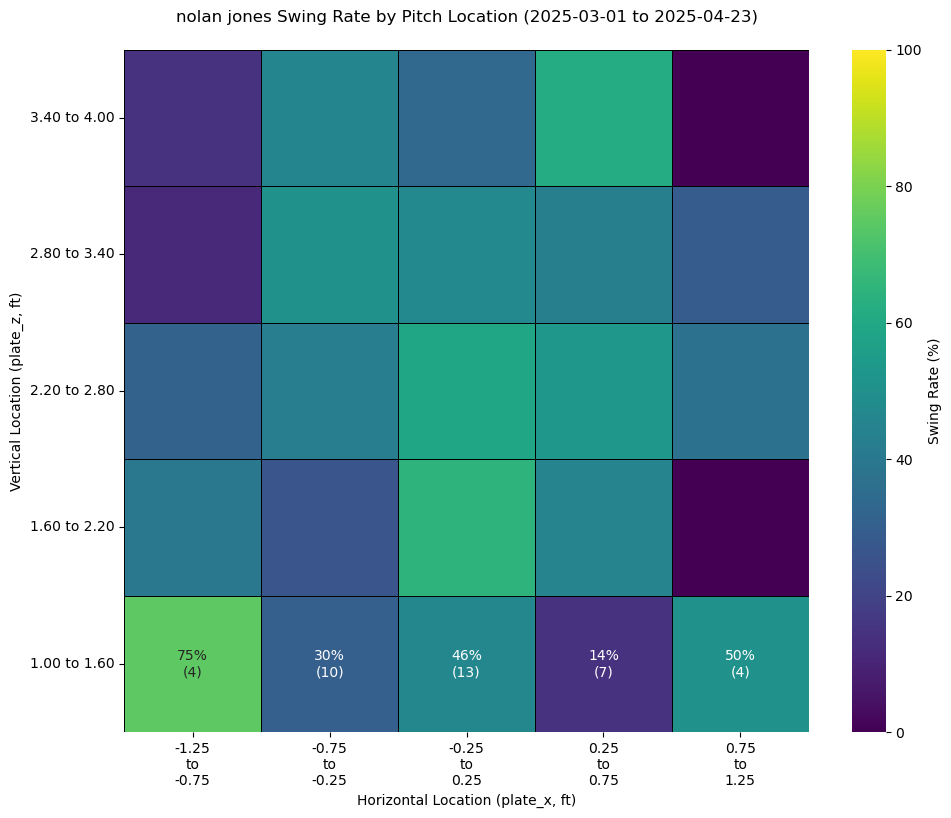

--- End of Block 11 ---


In [178]:
# Block 11: Visualize Swing Rate by Pitch Location (5x5 Grid)

print("\n--- Block 11: Analyzing Swing Rate by Pitch Location ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns
    required_cols = ['description', 'plate_x', 'plate_z']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for pitches with valid location and description
        pitch_data_sr = player_statcast_data[
            player_statcast_data['description'].notna() &
            player_statcast_data['plate_x'].notna() &
            player_statcast_data['plate_z'].notna()
        ].copy()

        # 2. Define descriptions that indicate a swing was taken
        swing_descriptions = {
            'hit_into_play', 'foul', 'swinging_strike', 'foul_tip',
            'foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'
            # Add others if needed based on data inspection
        }

        # 3. Create boolean column for swings
        pitch_data_sr['is_swing'] = pitch_data_sr['description'].isin(swing_descriptions)

        if not pitch_data_sr.empty:
            print(f"Found {len(pitch_data_sr)} pitches with location data to analyze for swing rate.")

            # --- Grid Definition (5x5) ---
            # Using the same bins as Block 6 for consistency
            x_bins = np.linspace(-1.25, 1.25, 6) # 6 edges = 5 bins
            z_bins = np.linspace(1.0, 4.0, 6)  # 6 edges = 5 bins

            pitch_data_sr['x_zone_bin'] = pd.cut(pitch_data_sr['plate_x'], bins=x_bins)
            pitch_data_sr['z_zone_bin'] = pd.cut(pitch_data_sr['plate_z'], bins=z_bins)

            # Drop pitches outside our defined grid
            pitch_data_sr.dropna(subset=['x_zone_bin', 'z_zone_bin'], inplace=True)

            if not pitch_data_sr.empty:
                # --- Calculation ---
                # Group by bins and calculate Swings and Total Pitches
                zone_swing_stats = pitch_data_sr.groupby(['z_zone_bin', 'x_zone_bin'], observed=False).agg(
                    Swings=('is_swing', 'sum'),
                    TotalPitches=('is_swing', 'count') # Count all pitches in bin
                ).reset_index()

                # Calculate Swing Rate (%), handle division by zero
                zone_swing_stats['SwingRate'] = (zone_swing_stats['Swings'] / zone_swing_stats['TotalPitches']) * 100
                # Keep NaN where TotalPitches=0

                # --- Pivot Data and Create Annotations ---
                swing_rate_heatmap_data = None
                annot_labels_sr = None
                try:
                    # Pivot Swing Rate, Swings, and Total Pitches
                    swing_rate_heatmap_data = zone_swing_stats.pivot_table(
                        index='z_zone_bin', columns='x_zone_bin', values='SwingRate', observed=False
                    )
                    swing_pivot = zone_swing_stats.pivot_table(
                        index='z_zone_bin', columns='x_zone_bin', values='Swings', observed=False, fill_value=0
                    )
                    total_pivot = zone_swing_stats.pivot_table(
                        index='z_zone_bin', columns='x_zone_bin', values='TotalPitches', observed=False, fill_value=0
                    )

                    # Create annotation labels (formatted strings: "Rate%\n(Pitches)")
                    annot_labels_sr = pd.DataFrame(index=swing_rate_heatmap_data.index, columns=swing_rate_heatmap_data.columns, dtype=str)
                    for row_idx in swing_rate_heatmap_data.index:
                        for col_idx in swing_rate_heatmap_data.columns:
                            rate = swing_rate_heatmap_data.loc[row_idx, col_idx]
                            total = total_pivot.loc[row_idx, col_idx]
                            if total > 0 and pd.notna(rate):
                                annot_labels_sr.loc[row_idx, col_idx] = f"{rate:.0f}%\n({total:.0f})" # Rate% (Total Pitches)
                            else:
                                annot_labels_sr.loc[row_idx, col_idx] = f"-\n({total:.0f})" # Show total pitches even if rate is NaN/0

                except Exception as e:
                     print(f"Error creating pivot table or annotations for swing rate heatmap: {e}")
                     swing_rate_heatmap_data = None # Prevent plotting if any part failed
                     annot_labels_sr = None

                # --- Visualization ---
                if swing_rate_heatmap_data is not None and not swing_rate_heatmap_data.empty and annot_labels_sr is not None:
                    plt.figure(figsize=(10, 9))
                    sns.heatmap(
                        swing_rate_heatmap_data,
                        annot=annot_labels_sr,    # Show Rate% and Total Pitches
                        fmt="",                # Use pre-formatted strings
                        cmap='viridis',        # Colormap (e.g., viridis, plasma)
                        linewidths=.5,
                        linecolor='k',
                        cbar_kws={'label': 'Swing Rate (%)'},
                        vmin=0, vmax=100      # Swing rate is 0-100%
                    )

                    # Improve axis labels to show bin ranges (or centers)
                    x_tick_labels = [f"{b.left:.2f}\nto\n{b.right:.2f}" for b in swing_rate_heatmap_data.columns]
                    z_tick_labels = [f"{b.left:.2f} to {b.right:.2f}" for b in swing_rate_heatmap_data.index]
                    plt.xticks(ticks=np.arange(len(swing_rate_heatmap_data.columns)) + 0.5, labels=x_tick_labels, rotation=0)
                    plt.yticks(ticks=np.arange(len(swing_rate_heatmap_data.index)) + 0.5, labels=z_tick_labels, rotation=0)
                    plt.gca().invert_yaxis() # Put lower zones at the bottom

                    plt.xlabel("Horizontal Location (plate_x, ft)")
                    plt.ylabel("Vertical Location (plate_z, ft)")
                    plot_title = f"{player_first_name} {player_last_name} Swing Rate by Pitch Location ({start_date} to {end_date})"
                    plt.title(plot_title, pad=20) # Add padding to title
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout slightly for title padding
                    plt.show()
                else:
                    print("No swing rate data available to plot heatmap after binning and pivoting.")
            else:
                print("No pitches found within the defined 5x5 grid boundaries.")
        else:
            print(f"No pitches with location data found for {player_first_name} {player_last_name} in the specified date range.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping swing rate analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping swing rate analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping swing rate analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 11 ---")


--- Block 12: Analyzing Whiff Rate by Pitch Location ---
Found 129 swings with location data to analyze for whiff rate.


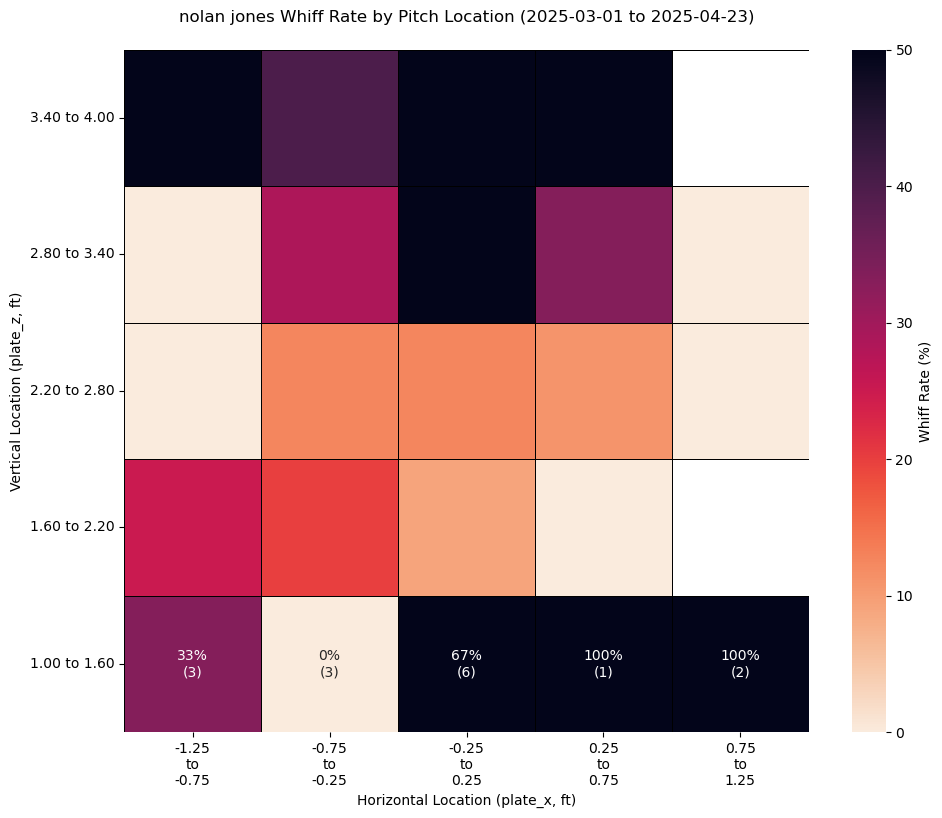

--- End of Block 12 ---


In [179]:
# Block 12: Visualize Whiff Rate by Pitch Location (5x5 Grid)

print("\n--- Block 12: Analyzing Whiff Rate by Pitch Location ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns
    required_cols = ['description', 'plate_x', 'plate_z']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for pitches with valid location and description
        pitch_data_wf = player_statcast_data[
            player_statcast_data['description'].notna() &
            player_statcast_data['plate_x'].notna() &
            player_statcast_data['plate_z'].notna()
        ].copy()

        # 2. Define descriptions for Swings and Whiffs
        swing_descriptions = {
            'hit_into_play', 'foul', 'swinging_strike', 'foul_tip',
            'foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'
        }
        whiff_descriptions = {'swinging_strike', 'missed_bunt'}

        # 3. Create boolean columns for Swings and Whiffs
        pitch_data_wf['is_swing'] = pitch_data_wf['description'].isin(swing_descriptions)
        # A whiff is a swing that matches the whiff descriptions
        pitch_data_wf['is_whiff'] = pitch_data_wf['is_swing'] & pitch_data_wf['description'].isin(whiff_descriptions)


        if not pitch_data_wf.empty:
             # Filter down to only include pitches that were swung at for rate calculation
             swing_data = pitch_data_wf[pitch_data_wf['is_swing'] == True].copy()

             if not swing_data.empty:
                print(f"Found {len(swing_data)} swings with location data to analyze for whiff rate.")

                # --- Grid Definition (5x5) ---
                x_bins = np.linspace(-1.25, 1.25, 6) # 6 edges = 5 bins
                z_bins = np.linspace(1.0, 4.0, 6)  # 6 edges = 5 bins

                swing_data['x_zone_bin'] = pd.cut(swing_data['plate_x'], bins=x_bins)
                swing_data['z_zone_bin'] = pd.cut(swing_data['plate_z'], bins=z_bins)

                # Drop swings outside our defined grid
                swing_data.dropna(subset=['x_zone_bin', 'z_zone_bin'], inplace=True)

                if not swing_data.empty:
                    # --- Calculation ---
                    # Group by bins and calculate Whiffs and Total Swings
                    zone_whiff_stats = swing_data.groupby(['z_zone_bin', 'x_zone_bin'], observed=False).agg(
                        Whiffs=('is_whiff', 'sum'),
                        TotalSwings=('is_swing', 'count') # Count rows where is_swing is True
                    ).reset_index()

                    # Calculate Whiff Rate (%), handle division by zero
                    zone_whiff_stats['WhiffRate'] = (zone_whiff_stats['Whiffs'] / zone_whiff_stats['TotalSwings']) * 100
                    # Keep NaN where TotalSwings=0

                    # --- Pivot Data and Create Annotations ---
                    whiff_rate_heatmap_data = None
                    annot_labels_wf = None
                    try:
                        # Pivot Whiff Rate and Total Swings
                        whiff_rate_heatmap_data = zone_whiff_stats.pivot_table(
                            index='z_zone_bin', columns='x_zone_bin', values='WhiffRate', observed=False
                        )
                        swing_pivot_wf = zone_whiff_stats.pivot_table(
                            index='z_zone_bin', columns='x_zone_bin', values='TotalSwings', observed=False, fill_value=0
                        )

                        # Create annotation labels (formatted strings: "Rate%\n(Swings)")
                        annot_labels_wf = pd.DataFrame(index=whiff_rate_heatmap_data.index, columns=whiff_rate_heatmap_data.columns, dtype=str)
                        for row_idx in whiff_rate_heatmap_data.index:
                            for col_idx in whiff_rate_heatmap_data.columns:
                                rate = whiff_rate_heatmap_data.loc[row_idx, col_idx]
                                total_swings = swing_pivot_wf.loc[row_idx, col_idx]
                                if total_swings > 0 and pd.notna(rate):
                                    annot_labels_wf.loc[row_idx, col_idx] = f"{rate:.0f}%\n({total_swings:.0f})" # Rate% (Total Swings)
                                else:
                                     # Show total swings even if rate is NaN/0
                                    annot_labels_wf.loc[row_idx, col_idx] = f"-\n({total_swings:.0f})"

                    except Exception as e:
                         print(f"Error creating pivot table or annotations for whiff rate heatmap: {e}")
                         whiff_rate_heatmap_data = None # Prevent plotting if any part failed
                         annot_labels_wf = None

                    # --- Visualization ---
                    if whiff_rate_heatmap_data is not None and not whiff_rate_heatmap_data.empty and annot_labels_wf is not None:
                        plt.figure(figsize=(10, 9))
                        sns.heatmap(
                            whiff_rate_heatmap_data,
                            annot=annot_labels_wf,    # Show Rate% and Total Swings
                            fmt="",                   # Use pre-formatted strings
                            cmap='rocket_r',          # Reversed colormap (darker = higher whiff rate)
                            linewidths=.5,
                            linecolor='k',
                            cbar_kws={'label': 'Whiff Rate (%)'},
                            vmin=0, vmax=50          # Set scale, whiff rates usually < 50-60% max typically
                        )

                        x_tick_labels = [f"{b.left:.2f}\nto\n{b.right:.2f}" for b in whiff_rate_heatmap_data.columns]
                        z_tick_labels = [f"{b.left:.2f} to {b.right:.2f}" for b in whiff_rate_heatmap_data.index]
                        plt.xticks(ticks=np.arange(len(whiff_rate_heatmap_data.columns)) + 0.5, labels=x_tick_labels, rotation=0)
                        plt.yticks(ticks=np.arange(len(whiff_rate_heatmap_data.index)) + 0.5, labels=z_tick_labels, rotation=0)
                        plt.gca().invert_yaxis() # Put lower zones at the bottom

                        plt.xlabel("Horizontal Location (plate_x, ft)")
                        plt.ylabel("Vertical Location (plate_z, ft)")
                        plot_title = f"{player_first_name} {player_last_name} Whiff Rate by Pitch Location ({start_date} to {end_date})"
                        plt.title(plot_title, pad=20)
                        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                        plt.show()
                    else:
                        print("No whiff rate data available to plot heatmap after binning and pivoting.")
                else:
                    print("No swings found within the defined 5x5 grid boundaries.")
             else:
                print(f"No swings found for {player_first_name} {player_last_name} in the specified date range to calculate whiff rate.")
        else:
            print(f"No pitches with location data found for {player_first_name} {player_last_name} in the specified date range.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping whiff rate analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping whiff rate analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping whiff rate analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 12 ---")


--- Block 13: Analyzing Rolling Chase Rate ---
Found 201 pitches outside the strike zone to analyze for chase rate.


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


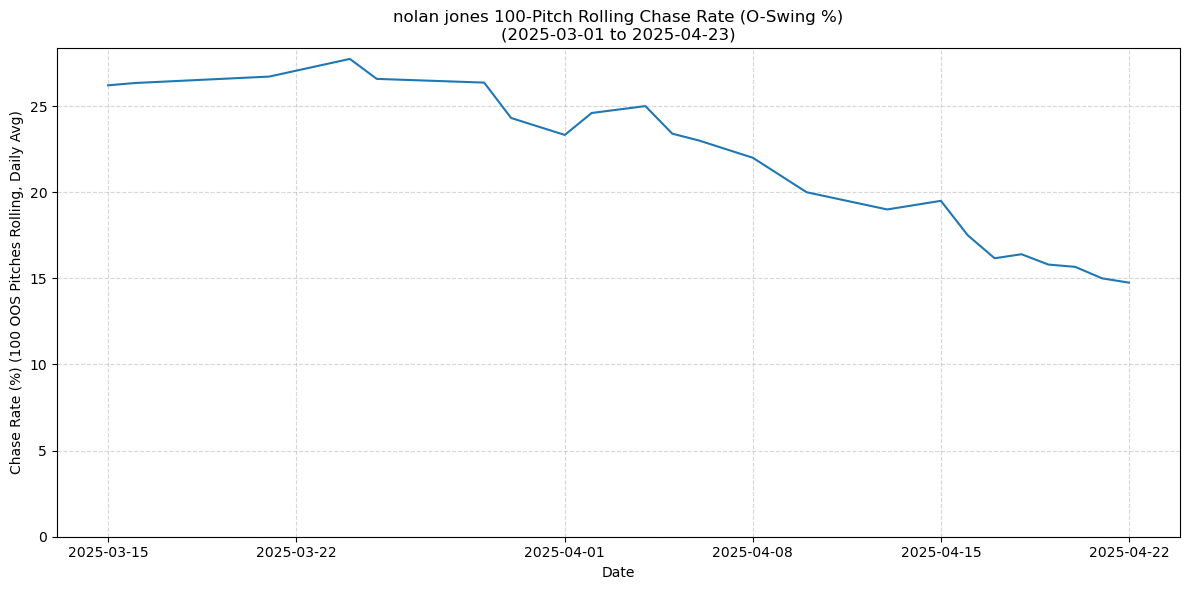

--- End of Block 13 ---


In [180]:
# Block 13: Rolling Chase Rate (O-Swing%) Over Time (Corrected for Duplicate Dates)

print("\n--- Block 13: Analyzing Rolling Chase Rate ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns
    required_cols = ['zone', 'description', 'game_date'] # Need zone to identify pitches outside SZ

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for pitches with valid zone, description, and game date
        pitch_data_cr = player_statcast_data[
            player_statcast_data['zone'].notna() &
            player_statcast_data['description'].notna() &
            player_statcast_data['game_date'].notna()
        ].copy()

        # 2. Define swing descriptions
        swing_descriptions = {
            'hit_into_play', 'foul', 'swinging_strike', 'foul_tip',
            'foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'
        }

        # 3. Create boolean column for swings
        pitch_data_cr['is_swing'] = pitch_data_cr['description'].isin(swing_descriptions)

        # 4. Identify pitches outside the standard 1-9 strike zones
        pitch_data_cr['is_out_of_zone'] = pitch_data_cr['zone'] >= 11

        # 5. Filter to *only* pitches outside the zone
        out_of_zone_pitches = pitch_data_cr[pitch_data_cr['is_out_of_zone'] == True].copy()


        if not out_of_zone_pitches.empty:
            # 6. Ensure game_date is datetime and sort chronologically
            out_of_zone_pitches['game_date'] = pd.to_datetime(out_of_zone_pitches['game_date'])
            out_of_zone_pitches.sort_values(by='game_date', inplace=True)

            print(f"Found {len(out_of_zone_pitches)} pitches outside the strike zone to analyze for chase rate.")

            # 7. Define rolling window size (number of *out-of-zone* pitches)
            window_size_chase = 100 # Use a 100-pitch rolling window (adjust as needed)

            # Check if there's enough data for the window
            if len(out_of_zone_pitches) >= window_size_chase:
                # --- Calculate Rolling Chase Rate ---
                rolling_col_name_chase = f'rolling_chase_rate_{window_size_chase}'
                out_of_zone_pitches[rolling_col_name_chase] = out_of_zone_pitches['is_swing'].rolling(
                    window=window_size_chase,
                    min_periods=window_size_chase // 2 # Allow calculation with half window at start
                ).mean() * 100

                # --- Aggregate by Date for Plotting (Fix for Duplicate Dates) --- ## ADDED STEP ##
                # Group by date and take the mean of the rolling value for that day
                daily_rolling_chase = out_of_zone_pitches.groupby('game_date')[rolling_col_name_chase].mean().reset_index()


                # --- Visualization ---
                plt.figure(figsize=(12, 6))

                sns.lineplot(
                    data=daily_rolling_chase, # <-- Plot the aggregated daily data
                    x='game_date',
                    y=rolling_col_name_chase, # <-- Use the same rolling column name
                )

                plt.title(f"{player_first_name} {player_last_name} {window_size_chase}-Pitch Rolling Chase Rate (O-Swing %)\n({start_date} to {end_date})")
                plt.xlabel("Date")
                plt.ylabel(f"Chase Rate (%) ({window_size_chase} OOS Pitches Rolling, Daily Avg)") # Updated label slightly
                plt.ylim(bottom=0) # Start y-axis at 0
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()

            else:
                print(f"Not enough out-of-zone pitch data ({len(out_of_zone_pitches)}) to calculate a {window_size_chase}-pitch rolling average.")
        else:
            print(f"No pitches identified as out of zone (Zone 11-14) found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping rolling chase rate analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping rolling chase rate analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping rolling chase rate analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 13 ---")


--- Block 14: Analyzing xwOBA by Pitch Type ---
Found 36 batted balls with xwOBA and pitch type data.


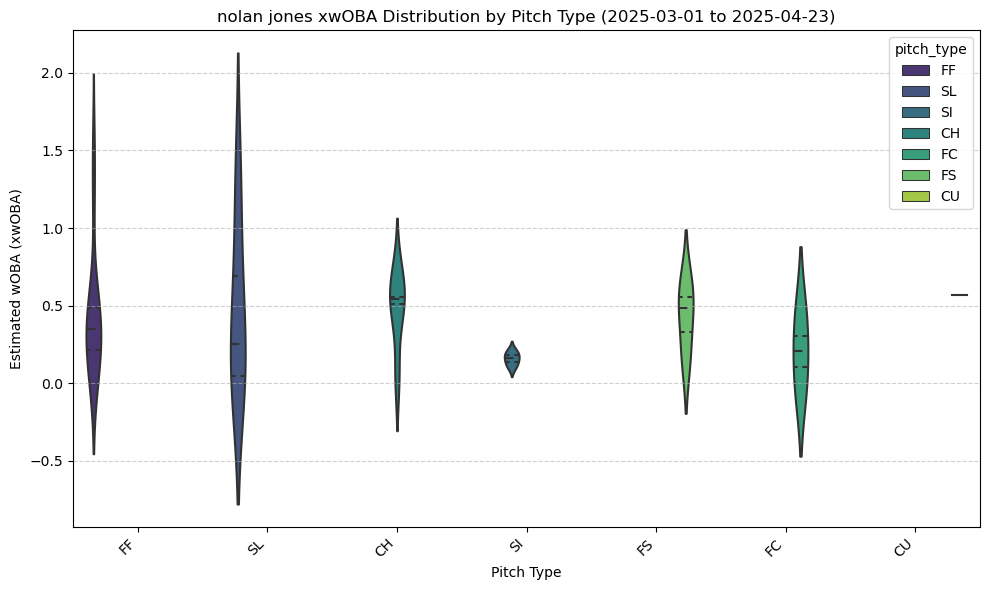

--- End of Block 14 ---


In [181]:
# Block 14: Visualize xwOBA by Pitch Type (Corrected for Warning)

print("\n--- Block 14: Analyzing xwOBA by Pitch Type ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # --- Data Preparation ---
    # 1. Define required columns
    xwoba_col = 'estimated_woba_using_speedangle'
    required_cols = [xwoba_col, 'pitch_type', 'launch_speed', 'launch_angle']

    # 2. Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # 3. Filter for batted balls with valid xwOBA and pitch_type
        batted_ball_data_xwoba = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna() &
            player_statcast_data[xwoba_col].notna() &
            player_statcast_data['pitch_type'].notna()
        ].copy()

        # 4. Check if any data remains after filtering
        if not batted_ball_data_xwoba.empty:
            print(f"Found {len(batted_ball_data_xwoba)} batted balls with xwOBA and pitch type data.")

            # --- Determine Plot Order ---
            pitch_type_order = batted_ball_data_xwoba['pitch_type'].value_counts().index.tolist()

            # --- Visualization (Corrected) --- ## MODIFIED CALL ##
            plt.figure(figsize=(10, 6))

            sns.violinplot(
                data=batted_ball_data_xwoba,
                x='pitch_type',
                y=xwoba_col,
                hue='pitch_type',      # <-- Assign x variable to hue
                order=pitch_type_order,
                palette='viridis',
                inner='quartiles',
                legend=False          # <-- Suppress redundant legend created by hue
            )

            plt.title(f"{player_first_name} {player_last_name} xwOBA Distribution by Pitch Type ({start_date} to {end_date})")
            plt.xlabel("Pitch Type")
            plt.ylabel("Estimated wOBA (xwOBA)")
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

        else:
            print(f"No batted balls with valid xwOBA ({xwoba_col}) and pitch type found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping xwOBA analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping xwOBA analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping xwOBA analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 14 ---")

In [182]:
# Block 15: Rolling xwOBA Over Time (Corrected for Duplicate Dates)

print("\n--- Block 15: Analyzing Rolling xwOBA ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # --- Data Preparation ---
    # 1. Define required columns
    xwoba_col = 'estimated_woba_using_speedangle' # Assumed xwOBA column
    required_cols = [xwoba_col, 'game_date', 'launch_speed', 'launch_angle']

    # 2. Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # 3. Filter for batted balls with valid xwOBA and game date
        batted_ball_data_rxwoba = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna() &
            player_statcast_data[xwoba_col].notna() &
            player_statcast_data['game_date'].notna()
        ].copy()

        if not batted_ball_data_rxwoba.empty:
            # 4. Ensure game_date is datetime and sort chronologically
            batted_ball_data_rxwoba['game_date'] = pd.to_datetime(batted_ball_data_rxwoba['game_date'])
            batted_ball_data_rxwoba.sort_values(by='game_date', inplace=True)

            print(f"Found {len(batted_ball_data_rxwoba)} batted balls with xwOBA data to analyze.")

            # 5. Define rolling window size (number of batted balls)
            window_size_xwoba = 50 # Use a 50-batted-ball rolling window (adjust as needed)

            # Check if there's enough data for the window
            if len(batted_ball_data_rxwoba) >= window_size_xwoba:
                # --- Calculate Rolling xwOBA ---
                rolling_col_name_xwoba = f'rolling_xwoba_{window_size_xwoba}' # Define column name
                batted_ball_data_rxwoba[rolling_col_name_xwoba] = batted_ball_data_rxwoba[xwoba_col].rolling(
                    window=window_size_xwoba,
                    min_periods=window_size_xwoba // 2 # Allow calculation with half window at start
                ).mean()

                # --- Aggregate by Date for Plotting (Fix for Duplicate Dates) --- ## ADDED STEP ##
                # Group by date and take the mean of the rolling value for that day
                daily_rolling_xwoba = batted_ball_data_rxwoba.groupby('game_date')[rolling_col_name_xwoba].mean().reset_index()


                # --- Visualization ---
                plt.figure(figsize=(12, 6))

                sns.lineplot(
                    data=daily_rolling_xwoba, # <-- Plot the aggregated daily data
                    x='game_date',
                    y=rolling_col_name_xwoba, # <-- Use the same rolling column name
                )

                plt.title(f"{player_first_name} {player_last_name} {window_size_xwoba}-Batted Ball Rolling xwOBA ({start_date} to {end_date})")
                plt.xlabel("Date")
                plt.ylabel(f"xwOBA ({window_size_xwoba}-BBE Rolling, Daily Avg)") # Updated label slightly
                # plt.ylim(bottom=0) # xwOBA can theoretically be slightly negative, but usually >= 0
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()

            else:
                print(f"Not enough batted ball data ({len(batted_ball_data_rxwoba)}) to calculate a {window_size_xwoba}-BBE rolling xwOBA.")
        else:
            print(f"No batted balls with valid xwOBA ({xwoba_col}) found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping rolling xwOBA analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping rolling xwOBA analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping rolling xwOBA analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 15 ---")


--- Block 15: Analyzing Rolling xwOBA ---
Found 36 batted balls with xwOBA data to analyze.
Not enough batted ball data (36) to calculate a 50-BBE rolling xwOBA.
--- End of Block 15 ---


In [183]:
# Block 16: Rolling Actual wOBA vs Rolling Expected wOBA (Corrected for Duplicate Dates)

print("\n--- Block 16: Analyzing Rolling Actual vs Expected wOBA ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # --- Define Columns ---
    woba_col = 'woba_value' # Actual wOBA based on PA outcome
    xwoba_col = 'estimated_woba_using_speedangle' # Expected wOBA based on contact quality
    required_cols = [woba_col, xwoba_col, 'game_date', 'launch_speed', 'launch_angle', 'events'] # Include events for context

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Prep Data for Rolling Actual wOBA ---
        pa_data_woba = player_statcast_data[
            player_statcast_data[woba_col].notna() &
            player_statcast_data['game_date'].notna()
        ].copy()
        pa_data_woba['game_date'] = pd.to_datetime(pa_data_woba['game_date'])
        pa_data_woba.sort_values(by='game_date', inplace=True)

        # --- Prep Data for Rolling xwOBA ---
        batted_ball_data_rxwoba = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna() &
            player_statcast_data[xwoba_col].notna() &
            player_statcast_data['game_date'].notna()
        ].copy()
        batted_ball_data_rxwoba['game_date'] = pd.to_datetime(batted_ball_data_rxwoba['game_date'])
        batted_ball_data_rxwoba.sort_values(by='game_date', inplace=True)


        # Check if we have enough data for both calculations
        window_size = 50 # Use same window size (e.g., 50 events - PAs for wOBA, BBEs for xwOBA)
        min_periods_calc = window_size // 2

        can_calc_woba = len(pa_data_woba) >= window_size
        can_calc_xwoba = len(batted_ball_data_rxwoba) >= window_size

        if not can_calc_woba:
            print(f"Not enough Plate Appearance data ({len(pa_data_woba)}) with '{woba_col}' to calculate a {window_size}-PA rolling average.")
        if not can_calc_xwoba:
             print(f"Not enough Batted Ball Event data ({len(batted_ball_data_rxwoba)}) with '{xwoba_col}' to calculate a {window_size}-BBE rolling average.")

        if can_calc_woba and can_calc_xwoba:
            print(f"Calculating {window_size}-event rolling wOBA and xwOBA...")

            # --- Calculate Rolling Averages ---
            rolling_woba_col = f'rolling_woba_{window_size}'
            rolling_xwoba_col = f'rolling_xwoba_{window_size}'

            pa_data_woba[rolling_woba_col] = pa_data_woba[woba_col].rolling(
                window=window_size, min_periods=min_periods_calc
            ).mean()

            batted_ball_data_rxwoba[rolling_xwoba_col] = batted_ball_data_rxwoba[xwoba_col].rolling(
                window=window_size, min_periods=min_periods_calc
            ).mean()

            # --- Aggregate by Date for Plotting (Fix for Duplicate Dates) --- ## ADDED STEP ##
            daily_rolling_woba = pa_data_woba.groupby('game_date')[rolling_woba_col].mean().reset_index()
            daily_rolling_xwoba = batted_ball_data_rxwoba.groupby('game_date')[rolling_xwoba_col].mean().reset_index()


            # --- Visualization ---
            plt.figure(figsize=(12, 6))
            ax = plt.gca() # Get current axes

            # Plot Rolling Actual wOBA (using aggregated data)
            sns.lineplot(
                data=daily_rolling_woba, # <-- Plot aggregated daily data
                x='game_date',
                y=rolling_woba_col,      # <-- Use rolling column name
                ax=ax,
                label=f'Actual wOBA ({window_size}-PA Roll)',
                color='dodgerblue'
            )

            # Plot Rolling Expected wOBA (xwOBA) (using aggregated data)
            sns.lineplot(
                data=daily_rolling_xwoba, # <-- Plot aggregated daily data
                x='game_date',
                y=rolling_xwoba_col,      # <-- Use rolling column name
                ax=ax,
                label=f'Expected wOBA ({window_size}-BBE Roll)',
                color='orangered',
                linestyle='--'
            )

            plt.title(f"{player_first_name} {player_last_name} {window_size}-Event Rolling wOBA vs. xwOBA ({start_date} to {end_date})")
            plt.xlabel("Date")
            plt.ylabel(f"wOBA / xwOBA ({window_size}-Event Rolling Avg, Daily)") # Updated label
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

        elif not can_calc_woba and not can_calc_xwoba:
             print("Insufficient data for both rolling wOBA and xwOBA calculations.")
        # else: (handled above - printed specific insufficient data message)

    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping Actual vs Expected analysis because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping Actual vs Expected analysis because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping Actual vs Expected analysis because the dataset was empty or player/date info is missing.")

print("--- End of Block 16 ---")


--- Block 16: Analyzing Rolling Actual vs Expected wOBA ---
Not enough Batted Ball Event data (36) with 'estimated_woba_using_speedangle' to calculate a 50-BBE rolling average.
--- End of Block 16 ---


In [184]:
# Block 17: Contact Quality Summary Table (Batter - Showing Unknown %)

print("\n--- Block 17: Analyzing Contact Quality Summary ---")

# Check prerequisite data and variables from Block 1 (Batter Notebook)
# Ensure variables like player_statcast_data, player_first_name, start_date, end_date exist
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['launch_speed', 'launch_angle', 'bb_type', 'events'] # Added events for barrel check context
    # Also needs is_barrel function defined (e.g., in Block 7a)

    # Check if required columns and helper function exist
    if all(col in player_statcast_data.columns for col in required_cols) and \
       'is_barrel' in locals() and callable(globals()['is_barrel']):

        # --- Data Preparation: Filter for Batted Balls ---
        batted_ball_data = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna()
        ].copy()

        if not batted_ball_data.empty:
            print(f"Calculating contact quality based on {len(batted_ball_data)} batted balls...")

            # --- Calculate Summary Metrics ---
            contact_metrics = {}
            contact_metrics["Batted Balls"] = len(batted_ball_data)
            contact_metrics["Avg Exit Velocity (mph)"] = batted_ball_data['launch_speed'].mean()
            contact_metrics["Max Exit Velocity (mph)"] = batted_ball_data['launch_speed'].max()
            contact_metrics["Avg Launch Angle (deg)"] = batted_ball_data['launch_angle'].mean()

            # Hard Hit Rate
            hard_hit_threshold = 95.0
            contact_metrics[f"Hard Hit Rate (%)"] = (batted_ball_data['launch_speed'] >= hard_hit_threshold).mean() * 100

            # Barrel Rate
            try:
                 batted_ball_data['is_barrel'] = batted_ball_data.apply(
                     lambda row: is_barrel(row['launch_speed'], row['launch_angle']), axis=1
                 )
                 contact_metrics["Barrel Rate (%)"] = batted_ball_data['is_barrel'].mean() * 100
            except Exception as e:
                 contact_metrics["Barrel Rate (%)"] = np.nan
                 print(f"Warning: Error calculating barrel rate - {e}")

            # --- Batted Ball Type Distribution (Including Unknown) --- ## MODIFIED ##
            if 'bb_type' in batted_ball_data.columns:
                 bb_type_dist = batted_ball_data['bb_type'].value_counts(dropna=False, normalize=True) * 100
                 contact_metrics["Ground Ball %"] = bb_type_dist.get('ground_ball', 0.0)
                 contact_metrics["Fly Ball %"] = bb_type_dist.get('fly_ball', 0.0)
                 contact_metrics["Line Drive %"] = bb_type_dist.get('line_drive', 0.0)
                 contact_metrics["Popup %"] = bb_type_dist.get('popup', 0.0)
                 # Explicitly get the percentage for NaN (Unknown)
                 contact_metrics["Unknown BB Type %"] = bb_type_dist.get(np.nan, 0.0)
            else:
                 print("Warning: 'bb_type' column not found, cannot calculate distribution.")
                 contact_metrics["Ground Ball %"] = np.nan
                 contact_metrics["Fly Ball %"] = np.nan
                 contact_metrics["Line Drive %"] = np.nan
                 contact_metrics["Popup %"] = np.nan
                 contact_metrics["Unknown BB Type %"] = np.nan
            # --------------------------------------------------------

            # --- Display Summary Table ---
            # Define order including the new Unknown %
            metric_order = [
                "Batted Balls", "Avg Exit Velocity (mph)", "Max Exit Velocity (mph)",
                "Avg Launch Angle (deg)", "Hard Hit Rate (%)", "Barrel Rate (%)",
                "Ground Ball %", "Fly Ball %", "Line Drive %", "Popup %", "Unknown BB Type %"
            ]
            # Format based on metric type
            summary_series_contact = pd.Series(dtype=object) # Create empty series first
            for metric in metric_order:
                 value = contact_metrics.get(metric)
                 if pd.notna(value):
                      if "%" in metric:
                          summary_series_contact[metric] = f"{value:.1f}%"
                      elif "Velocity" in metric or "Angle" in metric :
                          summary_series_contact[metric] = f"{value:.1f}"
                      elif "Batted Balls" in metric:
                           summary_series_contact[metric] = f"{value:.0f}"
                      else: # Default formatting if needed
                           summary_series_contact[metric] = value
                 else:
                      summary_series_contact[metric] = "N/A"


            title_contact = f"Contact Quality Summary for {player_first_name} {player_last_name} ({start_date} to {end_date})"
            print("\n" + "="*len(title_contact))
            print(title_contact)
            print("="*len(title_contact))
            print(summary_series_contact.to_string()) # Display as string

        else:
            print(f"No batted balls with launch speed and launch angle data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns or function missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        if 'is_barrel' not in locals() or not callable(globals()['is_barrel']): missing.append("'is_barrel' function")
        print(f"Skipping contact quality summary because required columns/functions are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping contact quality summary because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping contact quality summary because the dataset was empty or player/date info is missing.")

print("--- End of Block 17 ---")


--- Block 17: Analyzing Contact Quality Summary ---
Calculating contact quality based on 64 batted balls...

Contact Quality Summary for nolan jones (2025-03-01 to 2025-04-23)
Batted Balls                  64
Avg Exit Velocity (mph)     94.0
Max Exit Velocity (mph)    113.9
Avg Launch Angle (deg)      16.0
Hard Hit Rate (%)          53.1%
Barrel Rate (%)             7.8%
Ground Ball %              40.6%
Fly Ball %                 21.9%
Line Drive %               28.1%
Popup %                     9.4%
Unknown BB Type %           0.0%
--- End of Block 17 ---


In [185]:
# Block 18: Display Plate Discipline Metrics Table

print("\n--- Block 18: Calculating Plate Discipline Metrics ---")

# Check if data was loaded successfully in Block 1
if player_statcast_data is not None and not player_statcast_data.empty and player_first_name and start_date and end_date:

    # Define required columns
    # Need game_pk and at_bat_number for P/PA calculation
    required_cols = ['description', 'zone', 'game_pk', 'at_bat_number']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for pitches with valid description and zone
        pitch_data_pd = player_statcast_data[
            player_statcast_data['description'].notna() &
            player_statcast_data['zone'].notna() &
            player_statcast_data['game_pk'].notna() &      # Needed for PA count
            player_statcast_data['at_bat_number'].notna() # Needed for PA count
        ].copy()

        # 2. Define event descriptions
        swing_descriptions = {
            'hit_into_play', 'foul', 'swinging_strike', 'foul_tip',
            'foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'
        }
        whiff_descriptions = {'swinging_strike', 'missed_bunt'}

        if not pitch_data_pd.empty:
            # 3. Create boolean columns
            pitch_data_pd['is_swing'] = pitch_data_pd['description'].isin(swing_descriptions)
            pitch_data_pd['is_whiff'] = pitch_data_pd['description'].isin(whiff_descriptions) # Assumes whiffs are always swings
            pitch_data_pd['is_contact'] = pitch_data_pd['is_swing'] & (~pitch_data_pd['is_whiff'])
            pitch_data_pd['is_in_zone'] = (pitch_data_pd['zone'] >= 1) & (pitch_data_pd['zone'] <= 9)
            pitch_data_pd['is_out_of_zone'] = pitch_data_pd['zone'] >= 11 # Using standard O-Zone definition

            print(f"Calculating metrics based on {len(pitch_data_pd)} total pitches...")

            # --- Calculate Aggregate Counts ---
            total_pitches = len(pitch_data_pd)
            total_swings = pitch_data_pd['is_swing'].sum()
            total_contact = pitch_data_pd['is_contact'].sum()
            total_whiffs = pitch_data_pd['is_whiff'].sum()

            pitches_in_zone = pitch_data_pd['is_in_zone'].sum()
            swings_in_zone = pitch_data_pd.loc[pitch_data_pd['is_in_zone'], 'is_swing'].sum()
            contact_in_zone = pitch_data_pd.loc[pitch_data_pd['is_in_zone'], 'is_contact'].sum()

            pitches_out_zone = pitch_data_pd['is_out_of_zone'].sum()
            swings_out_zone = pitch_data_pd.loc[pitch_data_pd['is_out_of_zone'], 'is_swing'].sum()
            contact_out_zone = pitch_data_pd.loc[pitch_data_pd['is_out_of_zone'], 'is_contact'].sum()

            # Calculate distinct Plate Appearances
            total_pa = pitch_data_pd.groupby(['game_pk', 'at_bat_number'], observed=True).ngroups

            # --- Calculate Rates (Handle Division by Zero) ---
            swing_rate = (total_swings / total_pitches * 100) if total_pitches > 0 else np.nan
            contact_rate = (total_contact / total_swings * 100) if total_swings > 0 else np.nan
            whiff_rate = (total_whiffs / total_swings * 100) if total_swings > 0 else np.nan # SwStr% per swing

            zone_swing_rate = (swings_in_zone / pitches_in_zone * 100) if pitches_in_zone > 0 else np.nan
            zone_contact_rate = (contact_in_zone / swings_in_zone * 100) if swings_in_zone > 0 else np.nan

            chase_rate = (swings_out_zone / pitches_out_zone * 100) if pitches_out_zone > 0 else np.nan
            o_contact_rate = (contact_out_zone / swings_out_zone * 100) if swings_out_zone > 0 else np.nan

            p_pa = (total_pitches / total_pa) if total_pa > 0 else np.nan

             # --- Format Output Table ---
            metrics_dict_pd = {
                "Total Pitches Seen": f"{total_pitches:.0f}",
                "Total Plate Appearances": f"{total_pa:.0f}",
                "Pitches / PA": f"{p_pa:.2f}" if pd.notna(p_pa) else "N/A",
                "Overall Swing %": f"{swing_rate:.1f}%" if pd.notna(swing_rate) else "N/A",
                "Zone Swing % (Z-Swing)": f"{zone_swing_rate:.1f}%" if pd.notna(zone_swing_rate) else "N/A",
                "Chase % (O-Swing)": f"{chase_rate:.1f}%" if pd.notna(chase_rate) else "N/A",
                "Overall Contact %": f"{contact_rate:.1f}%" if pd.notna(contact_rate) else "N/A",
                "Zone Contact % (Z-Contact)": f"{zone_contact_rate:.1f}%" if pd.notna(zone_contact_rate) else "N/A",
                "Outside Contact % (O-Contact)": f"{o_contact_rate:.1f}%" if pd.notna(o_contact_rate) else "N/A",
                "Whiff % (per swing)": f"{whiff_rate:.1f}%" if pd.notna(whiff_rate) else "N/A",
             }

            # Create pandas Series for nice printing
            metrics_summary_pd = pd.Series(metrics_dict_pd)

            # --- Print Table ---
            title = f"Plate Discipline Summary for {player_first_name} {player_last_name} ({start_date} to {end_date})"
            print("\n" + "="*len(title))
            print(title)
            print("="*len(title))
            print(metrics_summary_pd.to_string()) # Use to_string for better alignment


        else:
            print(f"No pitches with description and zone data found for {player_first_name} {player_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping plate discipline metrics because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping plate discipline metrics because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping plate discipline metrics because the dataset was empty or player/date info is missing.")

print("--- End of Block 18 ---")


--- Block 18: Calculating Plate Discipline Metrics ---
Calculating metrics based on 394 total pitches...

Plate Discipline Summary for nolan jones (2025-03-01 to 2025-04-23)
Total Pitches Seen                 394
Total Plate Appearances            105
Pitches / PA                      3.75
Overall Swing %                  32.7%
Zone Swing % (Z-Swing)           47.2%
Chase % (O-Swing)                18.9%
Overall Contact %                69.8%
Zone Contact % (Z-Contact)       76.9%
Outside Contact % (O-Contact)    52.6%
Whiff % (per swing)              30.2%
--- End of Block 18 ---


In [186]:
# Block 20: Dictionary of Approximate Historical League Averages (2015-2024)

import numpy as np

# Sources: Search results synthesis (Baseball HQ for Chase Rate, estimates/ranges
# from FanGraphs/Savant/articles for others). All values are approximate.
league_historical_avg = {
    # Year: {Metric: Value}
    2015: {
        "Avg Exit Velocity (mph)": 88.3, # Estimate
        "Avg Launch Angle (deg)": 10.5, # Estimate/Trend
        "Hard Hit Rate (%)": 38.0,    # Estimate
        "Barrel Rate (%)": 6.5,       # Estimate
        "Chase Rate (O-Swing %)": 29.3, # Via Baseball HQ
        "Zone Contact Rate (%)": 87.0, # Estimate (high end)
        "Whiff Rate (% per swing)": 20.5, # Estimate (based on ~79.5% Contact)
    },
    2016: {
        "Avg Exit Velocity (mph)": 88.5, # Estimate
        "Avg Launch Angle (deg)": 10.8, # Via Rapsodo article / theScore
        "Hard Hit Rate (%)": 38.5,    # Estimate
        "Barrel Rate (%)": 7.0,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 28.7, # Via Baseball HQ
        "Zone Contact Rate (%)": 86.8, # Estimate
        "Whiff Rate (% per swing)": 21.0, # Estimate (based on ~79% Contact)
    },
    2017: {
        "Avg Exit Velocity (mph)": 88.6, # Estimate
        "Avg Launch Angle (deg)": 11.2, # Estimate/Trend (theScore shows ~11.8 in 2018)
        "Hard Hit Rate (%)": 39.0,    # Estimate
        "Barrel Rate (%)": 7.2,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 27.3, # Via Baseball HQ
        "Zone Contact Rate (%)": 86.5, # Estimate
        "Whiff Rate (% per swing)": 21.5, # Estimate (based on ~78.5% Contact)
    },
    2018: {
        "Avg Exit Velocity (mph)": 88.7, # Estimate
        "Avg Launch Angle (deg)": 11.8, # Estimate/Trend
        "Hard Hit Rate (%)": 39.0,    # Estimate
        "Barrel Rate (%)": 7.5,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 27.9, # Via Baseball HQ
        "Zone Contact Rate (%)": 86.0, # Estimate
        "Whiff Rate (% per swing)": 22.0, # Estimate (based on ~78% Contact)
    },
    2019: {
        "Avg Exit Velocity (mph)": 88.8, # Estimate
        "Avg Launch Angle (deg)": 12.7, # Via theScore (peak)
        "Hard Hit Rate (%)": 39.5,    # Estimate
        "Barrel Rate (%)": 7.8,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 29.0, # Via Baseball HQ
        "Zone Contact Rate (%)": 85.5, # Estimate
        "Whiff Rate (% per swing)": 22.5, # Estimate (based on ~77.5% Contact)
    },
    2020: { # Short season - metrics might be unusual
        "Avg Exit Velocity (mph)": 88.6, # Estimate
        "Avg Launch Angle (deg)": 12.7, # Via theScore (peak)
        "Hard Hit Rate (%)": 39.0,    # Estimate
        "Barrel Rate (%)": 8.0,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 27.5, # Via Baseball HQ
        "Zone Contact Rate (%)": 85.0, # Estimate
        "Whiff Rate (% per swing)": 23.0, # Estimate (based on ~77% Contact)
    },
    2021: {
        "Avg Exit Velocity (mph)": 88.7, # Estimate
        "Avg Launch Angle (deg)": 12.5, # Estimate/Trend (slight dip)
        "Hard Hit Rate (%)": 39.5,    # Estimate
        "Barrel Rate (%)": 8.5,       # Estimate/Trend (peak?)
        "Chase Rate (O-Swing %)": 27.8, # Via Baseball HQ
        "Zone Contact Rate (%)": 85.0, # Estimate
        "Whiff Rate (% per swing)": 23.0, # Estimate (based on ~77% Contact)
    },
    2022: {
        "Avg Exit Velocity (mph)": 88.8, # Estimate
        "Avg Launch Angle (deg)": 12.6, # Via theScore
        "Hard Hit Rate (%)": 40.0,    # Estimate
        "Barrel Rate (%)": 7.6,       # Estimate/Trend (dip from '21)
        "Chase Rate (O-Swing %)": 29.5, # Via Baseball HQ
        "Zone Contact Rate (%)": 84.5, # Estimate
        "Whiff Rate (% per swing)": 23.5, # Estimate (based on ~76.5% Contact)
    },
    2023: {
        "Avg Exit Velocity (mph)": 89.0, # Estimate
        "Avg Launch Angle (deg)": 12.3, # Via Rapsodo article
        "Hard Hit Rate (%)": 40.5,    # Estimate/Trend
        "Barrel Rate (%)": 8.0,       # Estimate/Trend
        "Chase Rate (O-Swing %)": 28.9, # Via Baseball HQ
        "Zone Contact Rate (%)": 85.0, # Estimate (~85.4 in one source)
        "Whiff Rate (% per swing)": 23.0, # Estimate (based on ~77% Contact)
    },
    2024: { # Using averages found previously for Block 19
        "Avg Exit Velocity (mph)": 89.0,
        "Avg Launch Angle (deg)": 12.5, # Estimate (similar to '23)
        "Hard Hit Rate (%)": 40.0,    # Rounded from ~40.5
        "Barrel Rate (%)": 8.0,       # Rounded from ~7.8-8.0 range
        "Chase Rate (O-Swing %)": 27.7, # Via Baseball HQ
        "Zone Contact Rate (%)": 85.0, # Estimate
        "Whiff Rate (% per swing)": 23.0, # Estimate
    }
}

print("Dictionary 'league_historical_avg' created with approximate yearly league averages.")
print("Note: These are estimates based on available data and trends.")

# Example of accessing a value:
# avg_ev_2023 = league_historical_avg.get(2023, {}).get("Avg Exit Velocity (mph)")
# print(f"\nApproximate League Avg EV in 2023: {avg_ev_2023}")

Dictionary 'league_historical_avg' created with approximate yearly league averages.
Note: These are estimates based on available data and trends.


In [187]:
# Block 19: Compare Player Metrics to Historical League Averages (Multi-Year Aware)

print("\n--- Block 19: Comparing Player Metrics to Relevant Historical League Average(s) ---")

# Check prerequisite data and variables from Block 1
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Check for Historical Averages Dictionary (from Block 20) ---
    if 'league_historical_avg' not in locals() and 'league_historical_avg' not in globals():
        print("Error: Historical league averages dictionary ('league_historical_avg') not found.")
        print("Please run Block 20 first to define it.")
        league_avg_dict_available = False
        comparison_years_str = "N/A"
        simple_avg_league_context = {}
    else:
        league_avg_dict_available = True
        print("Found historical league average data.")

        # --- Determine Relevant Years from Player Data --- ## MODIFIED LOGIC ##
        try:
            # Ensure 'game_date' column exists and is datetime
            if 'game_date' in player_statcast_data.columns:
                player_statcast_data['game_date'] = pd.to_datetime(player_statcast_data['game_date'])
                # Get unique years present in the player's data for the selected range
                player_years = sorted(player_statcast_data['game_date'].dt.year.unique())

                # Filter to years available in our historical dictionary
                relevant_years = [yr for yr in player_years if yr in league_historical_avg]

                if relevant_years:
                    min_yr, max_yr = min(relevant_years), max(relevant_years)
                    comparison_years_str = f"{min_yr}-{max_yr}" if min_yr != max_yr else str(min_yr)
                    print(f"Data covers years: {player_years}. Using league averages from {comparison_years_str} for comparison.")

                    # --- Calculate Simple Average of League Metrics Over Relevant Years ---
                    simple_avg_league_context = {}
                    metrics_to_average = list(league_historical_avg[relevant_years[0]].keys()) # Get metric names

                    for metric in metrics_to_average:
                        yearly_values = [league_historical_avg[yr].get(metric, np.nan) for yr in relevant_years]
                        # Calculate average, ignoring potential NaNs for a year/metric
                        avg_val = np.nanmean([v for v in yearly_values if pd.notna(v)])
                        simple_avg_league_context[metric] = avg_val

                    if not simple_avg_league_context:
                         print(f"Warning: Could not extract any league averages for years {relevant_years}.")
                         league_avg_dict_available = False # Treat as unavailable if no averages calculated

                else:
                    print(f"Warning: No historical league average data found for the years covered in the data ({player_years}).")
                    comparison_years_str = "N/A"
                    simple_avg_league_context = {}
                    league_avg_dict_available = False
            else:
                 print("Error: 'game_date' column missing from player data. Cannot determine relevant years.")
                 comparison_years_str = "N/A"
                 simple_avg_league_context = {}
                 league_avg_dict_available = False

        except Exception as e:
            print(f"Error determining relevant years or calculating average league context: {e}")
            comparison_years_str = "N/A"
            simple_avg_league_context = {}
            league_avg_dict_available = False

    # --- Define Required Columns ---
    required_cols = ['launch_speed', 'launch_angle', 'bb_type', 'description', 'zone']

    # Check if all required columns exist in player data
    if all(col in player_statcast_data.columns for col in required_cols):

        # --- Calculate Player Metrics (Overall for the period) ---
        # (Calculation logic remains the same as before)
        batted_ball_data = player_statcast_data[ (player_statcast_data['launch_speed'].notna()) & (player_statcast_data['launch_angle'].notna()) ].copy()
        player_metrics = {}
        if not batted_ball_data.empty:
            player_metrics["Avg Exit Velocity (mph)"] = batted_ball_data['launch_speed'].mean()
            hard_hit_threshold = 95.0
            player_metrics["Hard Hit Rate (%)"] = (batted_ball_data['launch_speed'] >= hard_hit_threshold).mean() * 100
            try:
                if 'is_barrel' in globals() and callable(globals()['is_barrel']):
                    batted_ball_data['is_barrel'] = batted_ball_data.apply(lambda row: is_barrel(row['launch_speed'], row['launch_angle']), axis=1)
                    player_metrics["Barrel Rate (%)"] = batted_ball_data['is_barrel'].mean() * 100
                else: player_metrics["Barrel Rate (%)"] = np.nan
            except NameError: player_metrics["Barrel Rate (%)"] = np.nan
        else:
            player_metrics["Avg Exit Velocity (mph)"] = np.nan
            player_metrics["Hard Hit Rate (%)"] = np.nan
            player_metrics["Barrel Rate (%)"] = np.nan
            print("Warning: No batted ball data found; cannot calculate EV, HH%, Barrel%.")

        pitch_data = player_statcast_data[ (player_statcast_data['description'].notna()) & (player_statcast_data['zone'].notna()) ].copy()
        if not pitch_data.empty:
            swing_descriptions = {'hit_into_play', 'foul', 'swinging_strike', 'foul_tip','foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'}
            whiff_descriptions = {'swinging_strike', 'missed_bunt'}
            pitch_data['is_swing'] = pitch_data['description'].isin(swing_descriptions)
            pitch_data['is_whiff'] = pitch_data['description'].isin(whiff_descriptions)
            pitch_data['is_contact'] = pitch_data['is_swing'] & (~pitch_data['is_whiff'])
            pitch_data['is_in_zone'] = (pitch_data['zone'] >= 1) & (pitch_data['zone'] <= 9)
            pitch_data['is_out_of_zone'] = pitch_data['zone'] >= 11
            total_swings = pitch_data['is_swing'].sum()
            total_whiffs = pitch_data['is_whiff'].sum()
            pitches_out_zone = pitch_data['is_out_of_zone'].sum()
            swings_out_zone = pitch_data.loc[pitch_data['is_out_of_zone'], 'is_swing'].sum()
            swings_in_zone = pitch_data.loc[pitch_data['is_in_zone'], 'is_swing'].sum()
            contact_in_zone = pitch_data.loc[pitch_data['is_in_zone'], 'is_contact'].sum()
            player_metrics["Chase Rate (O-Swing %)"] = (swings_out_zone / pitches_out_zone * 100) if pitches_out_zone > 0 else np.nan
            player_metrics["Zone Contact Rate (%)"] = (contact_in_zone / swings_in_zone * 100) if swings_in_zone > 0 else np.nan
            player_metrics["Whiff Rate (% per swing)"] = (total_whiffs / total_swings * 100) if total_swings > 0 else np.nan
        else:
             player_metrics["Chase Rate (O-Swing %)"] = np.nan
             player_metrics["Zone Contact Rate (%)"] = np.nan
             player_metrics["Whiff Rate (% per swing)"] = np.nan
             print("Warning: No pitch data found; cannot calculate discipline metrics.")

        # --- Create Comparison Table (Using simple avg of historical league values) ---
        comparison_data = []
        league_avg_col_name = f"League Avg ({comparison_years_str})" if comparison_years_str != "N/A" else "League Avg (N/A)"

        # Use the simple_avg_league_context dictionary calculated earlier
        for metric, p_val in player_metrics.items():
             lg_avg = simple_avg_league_context.get(metric, np.nan) # Get the simple average league value
             comparison_data.append({
                 "Metric": metric,
                 "Player": f"{p_val:.1f}" if pd.notna(p_val) else "N/A",
                 league_avg_col_name: f"{lg_avg:.1f}" if pd.notna(lg_avg) else "N/A"
             })

        comparison_df = pd.DataFrame(comparison_data)

        # --- Print Table ---
        title = f"Metric Comparison for {player_first_name} {player_last_name} ({start_date} to {end_date})"
        print("\n" + "="*len(title))
        print(title)
        print(f"(Compared to simple average of league values for years {comparison_years_str})") # Clarify comparison
        print("="*len(title))
        print("*Note: League Avg is simple avg of yearly values, not weighted by player activity.*")
        if not comparison_df.empty:
             print(comparison_df.to_markdown(index=False, numalign="left", stralign="left"))
        else:
             print("Could not calculate metrics for comparison.")

        # --- Optional: Simple Bar Plot Comparison (Updated) ---
        if league_avg_dict_available and comparison_years_str != "N/A" and not comparison_df.empty and comparison_df['Player'].ne("N/A").any():
            try:
                plot_df = comparison_df.copy()
                plot_df['Player Value'] = pd.to_numeric(plot_df['Player'].str.replace('%', '', regex=False), errors='coerce')
                plot_df['League Avg Value'] = pd.to_numeric(plot_df[league_avg_col_name].str.replace('%', '', regex=False), errors='coerce')
                plot_df.dropna(subset=['Player Value', 'League Avg Value'], inplace=True)

                if not plot_df.empty:
                    n_metrics = len(plot_df)
                    fig, axes = plt.subplots(n_metrics, 1, figsize=(8, n_metrics * 1.5), sharex=False)
                    if n_metrics == 1: axes = [axes]

                    fig.suptitle(f"{title}\n(vs Simple Avg League Values for {comparison_years_str})", y=1.03) # Updated plot title

                    for i, metric_row in plot_df.iterrows():
                        ax = axes[i]
                        metric_name = metric_row['Metric']
                        player_val = metric_row['Player Value']
                        league_val = metric_row['League Avg Value']

                        bars = ax.barh([f'League Avg ({comparison_years_str})', 'Player'], [league_val, player_val], color=['grey', 'cornflowerblue'], height=0.6)
                        ax.set_title(metric_name, loc='left', fontsize=10)
                        ax.bar_label(bars, fmt='%.1f', padding=3)
                        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
                        ax.set_yticks([])

                    plt.tight_layout(rect=[0, 0, 1, 0.98])
                    plt.show()

            except Exception as e:
                print(f"\nWarning: Could not generate comparison plots due to error: {e}")

    else:
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping metric comparison because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping metric comparison because player data was not loaded successfully in Block 1.")
else:
     print("Skipping metric comparison because the dataset was empty or player/date info is missing.")

print("--- End of Block 19 ---")


--- Block 19: Comparing Player Metrics to Relevant Historical League Average(s) ---
Found historical league average data.

Metric Comparison for nolan jones (2025-03-01 to 2025-04-23)
(Compared to simple average of league values for years N/A)
*Note: League Avg is simple avg of yearly values, not weighted by player activity.*
| Metric                   | Player   | League Avg (N/A)   |
|:-------------------------|:---------|:-------------------|
| Avg Exit Velocity (mph)  | 94       | N/A                |
| Hard Hit Rate (%)        | 53.1     | N/A                |
| Barrel Rate (%)          | 7.8      | N/A                |
| Chase Rate (O-Swing %)   | 18.9     | N/A                |
| Zone Contact Rate (%)    | 76.9     | N/A                |
| Whiff Rate (% per swing) | 30.2     | N/A                |
--- End of Block 19 ---


In [188]:
# Block 21: Calculate and Display Actual vs. Average Expected Outcomes Summary (Using wOBA)

print("\n--- Block 21: Calculating Actual vs. Average Expected Outcomes (wOBA Focus) ---")

# Check prerequisite data and variables from Block 1
if 'player_statcast_data' in locals() and player_statcast_data is not None and not player_statcast_data.empty and \
   'player_first_name' in locals() and player_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Columns ---
    woba_col = 'woba_value' # Actual wOBA based on PA outcome
    est_ba_col = 'estimated_ba_using_speedangle'
    est_woba_col = 'estimated_woba_using_speedangle'
    required_cols = ['events', woba_col, est_ba_col, est_woba_col,
                     'launch_speed', 'launch_angle', 'game_pk', 'at_bat_number']

    # Check if all required columns exist
    if all(col in player_statcast_data.columns for col in required_cols):

        # Initialize metrics dictionary
        summary_metrics = {}

        # --- Calculate Actual AVG (still needs ABs) & Actual wOBA ---
        pa_outcome_data = player_statcast_data[
            player_statcast_data['events'].notna() # Use non-null events to find PA outcomes
            # Alternatively, filter directly on woba_col.notna() for wOBA calculation
        ].copy()
        # pa_outcome_data.drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='last', inplace=True) # Optional safeguard

        actual_avg = np.nan
        actual_woba = np.nan

        if not pa_outcome_data.empty:
            print(f"Calculating actual stats based on {len(pa_outcome_data)} plate appearance outcomes...")
            # Define event sets needed for AB calculation
            hit_events = {'single', 'double', 'triple', 'home_run'}
            walk_events = {'walk', 'intent_walk'}
            hbp_events = {'hit_by_pitch'}
            sf_events = {'sac_fly'}
            sh_events = {'sac_bunt'}
            non_ab_events = walk_events | hbp_events | sf_events | sh_events

            # Calculate Counts for AVG
            total_pa = len(pa_outcome_data)
            H = pa_outcome_data['events'].isin(hit_events).sum()
            BB = pa_outcome_data['events'].isin(walk_events).sum()
            HBP = pa_outcome_data['events'].isin(hbp_events).sum()
            SF = pa_outcome_data['events'].isin(sf_events).sum()
            SH = pa_outcome_data['events'].isin(sh_events).sum()
            AB = total_pa - BB - HBP - SF - SH

            # Calculate Actual AVG
            actual_avg = (H / AB) if AB > 0 else 0.0
            summary_metrics["Actual AVG"] = f"{actual_avg:.3f}"

            # Calculate Actual wOBA (Mean of woba_value for PAs where it exists)
            # Ensure we only use rows where woba_value is not null for the mean calculation
            woba_values = pa_outcome_data[woba_col].dropna()
            if not woba_values.empty:
                 actual_woba = woba_values.mean()
                 summary_metrics["Actual wOBA"] = f"{actual_woba:.3f}"
            else:
                 summary_metrics["Actual wOBA"] = "N/A"
                 print(f"Warning: No valid '{woba_col}' values found to calculate Actual wOBA.")

        else:
            print("Warning: No plate appearance outcome data found; cannot calculate Actual AVG/wOBA.")
            summary_metrics["Actual AVG"] = "N/A"
            summary_metrics["Actual wOBA"] = "N/A"


        # --- Calculate Average Expected Outcomes on Contact ---
        batted_ball_data_exp = player_statcast_data[
            player_statcast_data['launch_speed'].notna() &
            player_statcast_data['launch_angle'].notna() &
            player_statcast_data[est_ba_col].notna() &
            player_statcast_data[est_woba_col].notna()
        ].copy()

        avg_xba_contact = np.nan
        avg_xwoba_contact = np.nan

        if not batted_ball_data_exp.empty:
            print(f"Calculating average expected outcomes based on {len(batted_ball_data_exp)} batted balls...")
            avg_xba_contact = batted_ball_data_exp[est_ba_col].mean()
            avg_xwoba_contact = batted_ball_data_exp[est_woba_col].mean()

            summary_metrics["Avg xBA on Contact"] = f"{avg_xba_contact:.3f}"
            summary_metrics["Avg xwOBA on Contact"] = f"{avg_xwoba_contact:.3f}"
        else:
            print("Warning: No batted balls with valid expected outcome data found.")
            summary_metrics["Avg xBA on Contact"] = "N/A"
            summary_metrics["Avg xwOBA on Contact"] = "N/A"


        # --- Calculate % Difference (Actual wOBA vs Avg xwOBA on Contact) --- ## MODIFIED ##
        pct_diff_woba = np.nan
        if pd.notna(actual_woba) and pd.notna(avg_xwoba_contact) and avg_xwoba_contact != 0:
            pct_diff_woba = ((actual_woba - avg_xwoba_contact) / avg_xwoba_contact) * 100
            summary_metrics["% Diff (wOBA vs xwOBA on Contact)"] = f"{pct_diff_woba:+.1f}%" # Show sign
        else:
             summary_metrics["% Diff (wOBA vs xwOBA on Contact)"] = "N/A"


        # --- Print Table ---
        # Ensure specific order if desired
        metric_order = [
            "Actual AVG", "Actual wOBA", "Avg xBA on Contact", "Avg xwOBA on Contact",
             "% Diff (wOBA vs xwOBA on Contact)"
        ]
        metrics_summary_combined = pd.Series(summary_metrics).reindex(metric_order)

        title = f"Actual vs. Avg Expected Outcomes for {player_first_name} {player_last_name} ({start_date} to {end_date})"
        print("\n" + "="*len(title))
        print(title)
        print("="*len(title))
        print(metrics_summary_combined.to_string())
        print("\nNote: 'Avg xBA/xwOBA on Contact' are averages of expected values for batted balls only.")
        print("      '% Diff' compares overall Actual wOBA to Avg xwOBA on Contact.")


    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in player_statcast_data.columns]
        print(f"Skipping outcomes summary because required columns are missing: {', '.join(missing)}")

elif player_statcast_data is None:
    print("Skipping outcomes summary because player data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping outcomes summary because the dataset was empty or player/date info is missing.")

print("--- End of Block 21 ---")


--- Block 21: Calculating Actual vs. Average Expected Outcomes (wOBA Focus) ---
Calculating actual stats based on 105 plate appearance outcomes...
Calculating average expected outcomes based on 36 batted balls...

Actual vs. Avg Expected Outcomes for nolan jones (2025-03-01 to 2025-04-23)
Actual AVG                            0.234
Actual wOBA                           0.285
Avg xBA on Contact                    0.348
Avg xwOBA on Contact                  0.400
% Diff (wOBA vs xwOBA on Contact)    -28.7%

Note: 'Avg xBA/xwOBA on Contact' are averages of expected values for batted balls only.
      '% Diff' compares overall Actual wOBA to Avg xwOBA on Contact.
--- End of Block 21 ---
